# Make Master CSV

In [2]:
import pandas as pd
import numpy as np
import json


# houseC = pd.read_csv('../../data/master/houseC.csv')
# ordonezB = pd.read_csv('../../data/master/ordonezB.csv')

with open('../../data/master/master.json') as f:

    masterJson = json.load(f)

In [66]:
#!/usr/bin/env python
config = {
"learning_rate" : 0.0001,
"num_epochs" : 150,
"decay" : 1e-5,
"input_dim" : 48,
"hidden_dim" : 64,
"layer_dim" : 1,
"output_dim" : 16,
"seq_dim" : 2,
"batch_size" :8,
"split_ratio" : 0.5,
"num_workers":4,
"accumulation_steps": 1,
"no_of_subset":30 ,
"subset_overlap_length": 2 ,
"resize_width": 120,
"resize_height": 97,
"image_width": 663,
"image_height": 446,
"ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},        
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

"merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": "grooming",
        "shave": "grooming",
        "takeMedication": "idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "idle",
        "Respirate": "relaxing",
        "Work": "idle",
        "Housekeeping": "idle",
        "Idle": "idle",
        "watchTV": "relaxing"
    },
 "ob_representation": False,
 "leaveOneHouseOut": True
}

In [67]:
df = pd.DataFrame()
for key in masterJson.keys():            
    currentCSV = key + '.csv'
    currentCSV = pd.read_csv('../../data/' + key + '/' + currentCSV)
    
    temp = currentCSV[['start', 'end', 'activity', 'time_of_the_day']].copy()
   
    for dictionary in masterJson[key]:
        genericColumn = list(dictionary.keys())[0]            
        specificColumn = dictionary[genericColumn][0]['name']             
        temp[genericColumn] = currentCSV[specificColumn]
        
    df = pd.concat([df, temp])
    df = df.fillna(-1)
    df.iloc[:,4:] = df[df.columns[4:]].apply(pd.to_numeric, downcast='integer')    


In [68]:
print('Before mapping \n\n')

print(df['activity'].groupby(df['activity']).count())
df['activity'] = df['activity'].map(config['merging_activties']).fillna(df['activity'])

print('\n \n \n After mapping \n\n ')
print(df['activity'].groupby(df['activity']).count())
df.to_csv('../../data/master/master.csv', index=False)

Before mapping 


activity
brushTeeth            173
eatBreakfast          136
eatDinner              49
eating                365
getDressed            128
getDrink               80
getSnack              486
goToBed             44029
grooming              569
idle                16033
leaveHouse          50863
prepareBreakfast      676
prepareDinner         830
prepareLunch          779
shave                  63
takeMedication         11
takeShower            715
useToilet             914
washDishes             31
watchTV             17571
Name: activity, dtype: int64

 
 
 After mapping 

 
activity
brushTeeth            173
eating                550
getDrink               80
getSnack              486
goToBed             44029
grooming              760
idle                16044
leaveHouse          50863
prepareBreakfast      676
prepareDinner         830
prepareLunch          779
relaxing            17571
takeShower            715
useToilet             914
washDishes             31
N

# Getting Unique activities in CSV's


In [196]:
!pwd

/home/harsh/Downloads/Thesis/Graph/dgl/related_code/3-basics


# Making Nodes and Edges for graph through house json file

In [3]:

import os
import json
import pandas as pd
import numpy as np
import json

file_names = ['houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB']

rooms_across_all_house = {'Toilet': 0, 'Bathroom': 1, 'Kitchen': 2, 'Bedroom': 3, 'Hall': 4, 'Office': 5, 'LivingRoom': 6, 'OutsideRegion': 7}

total_rooms = 0
for file_name in file_names:

    json_file_name = file_name + '.json'
    csv_file_name = file_name + '.csv'

    json_file = os.path.join('../../data', file_name, json_file_name)
    csv_file = os.path.join('../../data', file_name, csv_file_name)

    with open(json_file) as f:
        json_file = json.load(f)

    csv_file = pd.read_csv(csv_file)

    locations = json_file['locations']

    sensors = json_file['sensors']
    def sensor_place_in_house_ID(col_name, location_id=1):
        # Find sensor dict and take the location key, whose name matches with col names
        location_id = [x['location'] for x in sensors if x['name'] == col_name][0]
        if len(location_id) == 1:
            location_type = [x['type'] for x in locations if x['id'] == location_id[0]][0]
            return [rooms_across_all_house[location_type]]
        else:
            items = []
            for item in location_id:
                location_type = [x['type'] for x in locations if x['id'] == item][0]
                items.append(rooms_across_all_house[location_type])
            return items


    # get rooms as nodes first, by giving them id and make a dictionary of their features
    nodes_dictionary_list = []
    d = {}

    # Sensor place in house will be taken from here, the index will represent place in house of sensor
    rooms = [name['type'] for name in locations]
    count = 0
    # convert it into a dictionary list
    for i, node in enumerate(rooms):
        d = {}
        d['Id'] = count
        d['Object'] = node

        d['Value'] = -1
        d['place_in_house'] = rooms_across_all_house[node]
        d['Type'] = 1

        # Room id will be taken from here
        count += 1
        nodes_dictionary_list.append(d)
        # if node not in rooms_across_all_house:
        #     rooms_across_all_house[node] = total_rooms
        #     total_rooms += 1

    # csv column names
    col = list(csv_file.columns[4:].values)

    for i, col_name in enumerate(col):
        Id = i
        Object = col_name.split('_')[0]
        Value = -1
        place_in_house = sensor_place_in_house_ID(Object)
        Type = 0

        # Append to nodes_dictionary_list

        for location_id in place_in_house:
            d = {}
            d['Id'] = len(nodes_dictionary_list)
            d['Object'] = Object
            d['Value'] = -1
            d['Type'] = 0
            d['place_in_house'] = location_id
            nodes_dictionary_list.append(d)

    # Adding time of the day as the last node

    d = {}
    d['Id'] = len(nodes_dictionary_list)
    d['Object'] = 'time_of_the_day'
    d['Value'] = -1
    d['Type'] = -1
    d['place_in_house'] = -1

    nodes_dictionary_list.append(d)

    # print(list(nodes_dictionary_list))

    import csv

    toCSV = nodes_dictionary_list

    # json_file = os.path.join('../../data', file_name)

    keys = toCSV[0].keys()
    with open(os.path.join('../../data', file_name, 'nodes.csv'), 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(toCSV)

    # Write Edge.csv

    # Make a list of src and destination and write it via pandas
    Src = []
    Dst = []
    for node_dict in nodes_dictionary_list:
        if node_dict['Type'] == 0:
            # Birectional Edges
            Src.append(node_dict['Id'])
            Dst.append(node_dict['place_in_house'])

            Src.append(node_dict['place_in_house'])
            Dst.append(node_dict['Id'])

    # Connect rooms

    for location_dict in locations:
        src_location_id = rooms.index(location_dict['type'])

        reaches_list = location_dict['reaches']
        for reach_id in reaches_list:
            Type = [x['type'] for x in locations if x['id'] == reach_id][0]
            dst_location_id = rooms.index(Type)
            Src.append(src_location_id)
            Dst.append(dst_location_id)

    Src.append(nodes_dictionary_list[-1]['Id'])
    Dst.append(nodes_dictionary_list[-1]['Id'])

    df = pd.DataFrame({'Src': Src, 'Dst': Dst})
    df.to_csv(os.path.join('../../data', file_name, 'bidrectional_edges.csv'), index=False)
# print(rooms_across_all_house)

# Maping Activity 

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import json

In [3]:
# {'name': 'brushTeeth', 'id': 0}

merging_activties = {
"loadDishwasher": "washDishes",
"unloadDishwasher": "washDishes",
"loadWashingmachine": "washClothes",
"unloadWashingmachine": "washClothes",
"receiveGuest": "relaxing",
"eatDinner": "eating",
"eatBreakfast": "eating",
"getDressed": " grooming",
"shave": "grooming",
"getDressed": " grooming",
"takeMedication": "idle",
"leave_Home": "leaveHouse",
"Sleeping": "goToBed",
"Bed_to_Toilet": "useToilet",
"Enter_Home": "idle",
"Respirate": "relaxing",
"Work": "idle",
"Housekeeping": "idle",
"watchTV": "relaxing"
}

In [4]:
houseA = ['idle', 'leaveHouse', 'eating', 'useToilet', 'takeShower', 'brushTeeth', 'goToBed', 'prepareBreakfast', 'prepareDinner', 'getSnack', 'getDrink', 
    'loadDishwasher', 'unloadDishwasher', 'storeGroceries', 'loadWashingmachine', 'unloadWashingmachine', 'receiveGuest']


houseB = ['brushTeeth', 'eatBreakfast', 'eatDinner', 'getDressed', 'getDrink', 'goToBed', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'takeShower', 'useToilet', 'washDishes']


houseC = ['brushTeeth', 'eating', 'getDressed', 'getDrink', 'getSnack', 'goToBed', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'prepareLunch', 'shave', 'takeMedication', 'takeShower', 'useToilet']

#aruba = ['Bed_to_Toilet', 'Eating', 'Enter_Home', 'Housekeeping', 'Idle', 'Leave_Home', 'Meal_Preparation', 'Relax', 'Respirate', 'Sleeping', 'Wash_Dishes', 'Work']


ordonezA = ['idle', 'goToBed', 'useToilet', 'takeShower', 'prepareBreakfast', 'prepareLunch', 'grooming', 'watchTV', 'leaveHouse', 'getSnack', 'prepareDinner']

ordonezB = ['getSnack', 'goToBed', 'grooming', 'idle', 'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'prepareLunch', 'takeShower', 'useToilet', 'watchTV']

In [5]:
# all_houses = [houseA, houseB, houseC, ordonezA, ordonezB]
all_houses = [houseA]
final_activity_list = []

for house in all_houses:
    for activity in house:
        try:
            mappedActivity = merging_activties[activity]
            final_activity_list.append(mappedActivity)
        except:
            final_activity_list.append(activity)
            

In [6]:
final_activity_list = [x for x in final_activity_list]

In [7]:
final_activity_list = (set(final_activity_list))

In [8]:
final_activity_list = [{"name": activity, "id":idx} for idx, activity in enumerate(final_activity_list)]

In [9]:
final_activity_list

[{'name': 'takeShower', 'id': 0},
 {'name': 'idle', 'id': 1},
 {'name': 'washClothes', 'id': 2},
 {'name': 'getSnack', 'id': 3},
 {'name': 'washDishes', 'id': 4},
 {'name': 'prepareBreakfast', 'id': 5},
 {'name': 'prepareDinner', 'id': 6},
 {'name': 'eating', 'id': 7},
 {'name': 'brushTeeth', 'id': 8},
 {'name': 'storeGroceries', 'id': 9},
 {'name': 'relaxing', 'id': 10},
 {'name': 'goToBed', 'id': 11},
 {'name': 'getDrink', 'id': 12},
 {'name': 'leaveHouse', 'id': 13},
 {'name': 'useToilet', 'id': 14}]

In [1]:
np.unique(houseA['activity'])

# Convert to OB representation for single CSV

In [1]:
# (a) x <= 5
# (d) 60 < x <= 120 
# (f) 150 < x <= 660
# (b) 5 < x <= 30 
# (e) 120 < x <= 150 
# (g) x > 660
# (c) 30 < x <= 60

import pandas as pd
import numpy as np
import pandas as pd
import json

In [2]:
df = pd.read_csv('../../data/master/master.csv')
# df = pd.read_csv('../../data/houseC/houseC.csv')

In [3]:
col = df.columns.tolist()

In [6]:
seq_length = 1
prev_index = 0
seq_list = []

# Go over Master.csv line by line, this loop will give you each unique sequence frequency.
# you can get ith index from this by just adding sequence till i and subtacting 1 from it. 
for index, row in df[:-1].iterrows():     
    # Starting from 0 as prev_index concatenate sensor values
    prev_value = df.iloc[prev_index, 4:]
    prev_value = ''.join(map(str, prev_value.values))
    
    # if pervious value == next to the row that you are currently operating. Increment the sequence_length
    if prev_value == ''.join(map(str, df.iloc[index + 1, 4:].values)):
        seq_length += 1
        if index == len(df) - 2:
            seq_list.append(seq_length)
            seq_length = 1
            prev_index = index + 1  
        
    
        
    # Else, append the seq_length, seq_length to 1 and make prev_index = next row. because
    # till index row things are done. 
    else:        
        seq_list.append(seq_length)
        seq_length = 1
        prev_index = index + 1           


# sum_list =  row to be choosen in new dataframe.
sum_list = []
for i in range(len(seq_list)):
    if i == 0:
        sum_list.append(sum(seq_list[:i + 1]) - 1)
    else:
        sum_list.append(sum(seq_list[:i + 1]) - 2)
# print('final rows list  ',sum_list)

# Seq_list = unary representation for each unique
# print('seq list ',  seq_list)


truncatedDataframe = pd.DataFrame([])

for index, x in enumerate(sum_list):    
        truncatedDataframe = truncatedDataframe.append(df.iloc[sum_list[index] ,:])

truncatedDataframe = truncatedDataframe[col]
truncatedDataframe.head()
    
# convert each value according to bin, 
bins_seq_list = np.copy(seq_list)
for i, x in enumerate(bins_seq_list):
    if x <= 5:
        bins_seq_list[i] = 1
    elif 5 < x <= 30:
        bins_seq_list[i] = 2
    elif 30 < x <= 60:
        bins_seq_list[i] = 3
    elif 60 < x <= 120:
        bins_seq_list[i] = 4
    elif 120 < x <= 150:
        bins_seq_list[i] = 5
    elif 150 < x <= 660:
        bins_seq_list[i] = 6
    elif x > 660:
        bins_seq_list[i] = 7
        

            

In [7]:
seq_list

[188,
 1,
 1,
 1,
 18,
 1,
 2,
 2,
 2,
 1,
 62,
 1,
 1,
 456,
 1,
 5,
 2,
 1,
 2,
 1,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 18,
 1,
 2,
 3,
 9,
 2,
 1,
 1,
 2,
 4,
 1,
 1,
 1,
 4,
 1,
 16,
 1,
 1,
 1,
 2,
 2,
 9,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 3,
 1,
 13,
 1,
 1,
 19,
 1,
 1,
 13,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 4,
 4,
 8,
 4,
 7,
 1,
 12,
 1,
 1,
 10,
 1,
 2,
 1,
 4,
 4,
 4,
 1,
 3,
 1,
 15,
 1,
 18,
 1,
 8,
 2,
 1,
 1,
 1,
 1,
 1,
 27,
 1,
 1,
 7,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 28,
 1,
 10,
 1,
 45,
 1,
 1,
 1,
 18,
 1,
 1,
 4,
 1,
 7,
 1,
 1,
 62,
 1,
 4,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 114,
 1,
 1,
 1,
 6,
 1,
 4,
 1,
 2,
 1,
 1,
 78,
 1,
 1,
 1,
 1,
 15,
 1,
 1,
 39,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 100,
 1,
 1,
 1,
 442,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 4,
 1,
 1,
 2,
 2,
 5,
 4,
 4,
 2,
 3,
 3,
 1,
 4,
 1,
 10,
 1,
 17,
 1,
 1,
 1,
 1,
 34,
 1,
 2,
 1,
 168,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 10,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,


In [8]:

# convert to unary representation
final_unary_list = []

for i in range(len(bins_seq_list)):
    gn_list = 7 * [0]
    ones_list = np.ones(bins_seq_list[i], dtype = int)
    zero_list = np.zeros(7 - bins_seq_list[i], dtype = int)
    unary_list = np.append(ones_list , zero_list)
    final_unary_list.append(unary_list)
    

In [9]:
# [{"name": activity, "id":idx} for idx, activity in enumerate(pd.unique( df['activity']))]

In [10]:
truncatedDataframe['one_hot_time_of_the_day'] = round(truncatedDataframe['time_of_the_day'] * 24)
final_one_hot_time_of_day = []
for val in truncatedDataframe['one_hot_time_of_the_day']:            
    a = np.zeros(25, dtype = int)
    a[int(val)] =  1
    final_one_hot_time_of_day.append(a)


In [11]:
truncatedDataframe = truncatedDataframe.set_index(np.arange(truncatedDataframe.shape[0]))

In [12]:
# type(final_one_hot_time_of_day[0][0])

In [13]:
# truncatedDataframe['one_hot_time_of_the_day'] = final_one_hot_time_of_day

In [14]:
np.array(final_one_hot_time_of_day).shape
one_hot_time_of_the_day = pd.DataFrame(np.array(final_one_hot_time_of_day), columns=['one_hot_' + str(i) for i in range(np.array(final_one_hot_time_of_day).shape[1])])
# one_hot_time_of_the_day

In [15]:

final_unary_list = pd.DataFrame(final_unary_list, columns=['unary_' + str(i) for i in range(np.array(final_unary_list).shape[1])])

# final_unary_list



In [16]:
final_csv = pd.concat([truncatedDataframe, one_hot_time_of_the_day, final_unary_list], axis =1)


In [17]:
# Shuffling the column to restore the original order
col = final_csv.columns.values.tolist()

cols = ['start', 'end', 'activity', 'time_of_the_day', 'one_hot_time_of_the_day']

col = [x for x in col if x not in cols]
col.insert(0, 'start')
col.insert(1, 'end')
col.insert(2, 'activity')
col.insert(3, 'time_of_the_day')

final_csv = final_csv[col]

In [18]:
final_csv.iloc[:, 3:] = final_csv.iloc[:, 3:].apply(pd.to_numeric, downcast='integer')

In [22]:
final_csv.to_csv('../../data/master/ob_master.csv', index=False)
final_csv.to_csv('../../../../Research/data/master/ob_master.csv', index=False)    

# final_csv.to_csv('../../data/houseC/ob_houseC.csv', index=False)


In [20]:
# final_csv.to_pickle('../../../../../Thesis/dummyTestforPycharm/data/houseA/one_hot.csv')

# final_csv.to_csv('../../../../../Thesis/dummyTestforPycharm/data/houseA/one_hot.csv', index=False)

In [23]:
final_csv.head()


,start,end,activity,time_of_the_day,BedPressureRight,BasinBathroomPIR,ToiletFlushSensor,ShowerBathroomPIR,FridgeMagnetic,GroceriesCupboard,...,one_hot_22,one_hot_23,one_hot_24,unary_0,unary_1,unary_2,unary_3,unary_4,unary_5,unary_6
0,12-Nov-2012 00:21:00,12-Nov-2012 00:21:59,relaxing,0.014583,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,0
1,12-Nov-2012 00:21:00,12-Nov-2012 00:21:59,relaxing,0.014583,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,12-Nov-2012 00:22:00,12-Nov-2012 00:22:59,relaxing,0.015278,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,12-Nov-2012 00:23:00,12-Nov-2012 00:23:59,idle,0.015972,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,12-Nov-2012 00:41:00,12-Nov-2012 00:41:59,relaxing,0.028472,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


### Decompress the above CSV to original so as to use them in evaluation, just to get labels, along with Time of day and frequency of repeating as one hot vectors

In [24]:
import datetime as dt
from datetime import timedelta

compressed = final_csv
compressed = compressed.loc[compressed.index.repeat(seq_list)].reset_index(drop=True)

master = df
compressed['start'] = master['start']
compressed['end'] = master['end']


compressed.to_csv('../../data/master/decompressed_OB_master.csv', index=False)
compressed.to_csv('../../../../Research/data/master/decompressed_OB_master.csv', index=False)


In [ ]:
final_csv.head()

## Making confusion matrix


In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
def getClassnameFromID(train_label):
    ActivityIdList = config['ActivityIdList']
    train_label = [x for x in ActivityIdList if x["id"] == int(train_label)]
    return train_label[0]['name']


In [42]:
test_CfMatrix  = np.load('../../data/all_houses/test_confusion_matrix.npy')
train_cfMatrix  = np.load('../../data/all_houses/train_confusion_matrix.npy')

In [84]:
config = {
    "batch_size": 32,
    "ActivityIdList":
       [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

    "merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "Idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "Idle",
        "Respirate": "relaxing",
        "Work": "Idle",
        "Housekeeping": "Idle",
        "watchTV": "relaxing"
    }
}

# df_cm_train = pd.DataFrame(train_cfMatrix, index=[getClassnameFromID(i) for i in range(train_cfMatrix.shape[0])],
#                      columns=[getClassnameFromID(i) for i in range(train_cfMatrix.shape[0])], dtype=float)


# df_cm_test = pd.DataFrame(test_CfMatrix, index=[getClassnameFromID(i) for i in range(test_CfMatrix.shape[0])],
#                      columns=[getClassnameFromID(i) for i in range(test_CfMatrix.shape[0])], dtype=float)


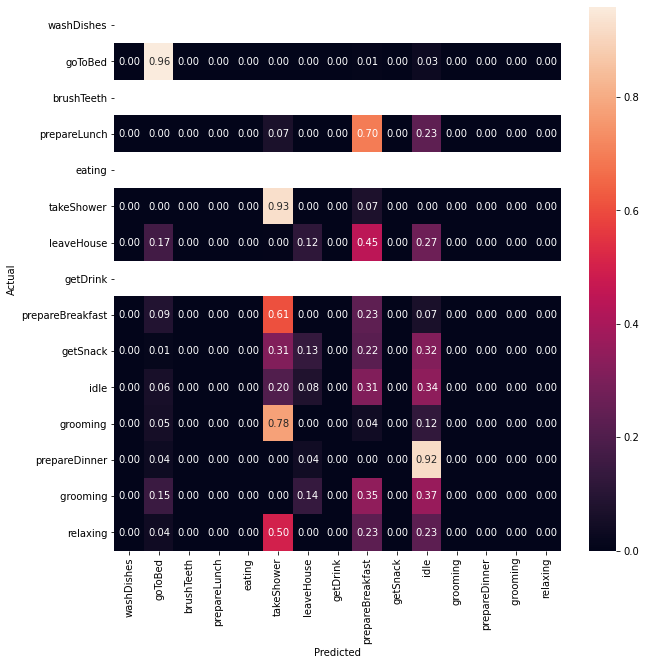

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numpy as np



def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# ax= plt.subplot()
# sn.heatmap(mat, annot=True, fmt = 'g', cmap='Blues', ax=ax)
# ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
# # plt.savefig('train_Cf_matrix_allHouse_OneDayValidationFromEachHouse')

# plot_confusion_matrix(np.array(mat), target_names = labels)




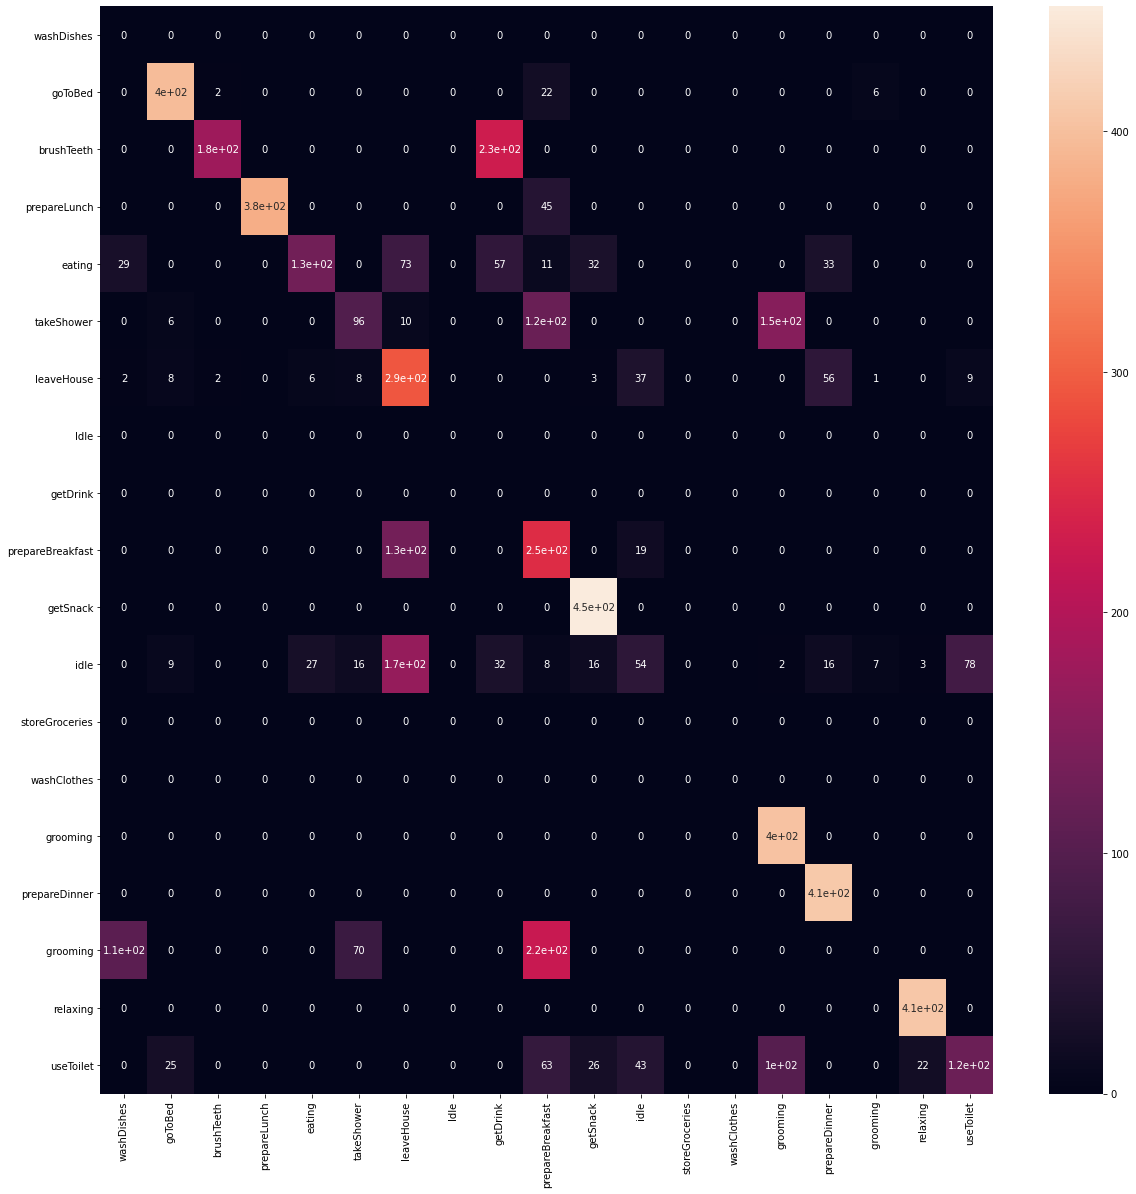

In [46]:
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm_test, annot=True)
# plt.show()
plt.savefig('test_Cf_matrix_allHouse_OneDayValidationFromEachHouse')


In [30]:
total_ids = np.arange(len(labels), dtype=int)
valid_idx = []
valid_idx.extend(total_ids[7183: 8622])
valid_idx.extend(total_ids[37088+4756: 37088+6195])
valid_idx.extend(total_ids[37088 + 20583 + 17353:  37088 + 20583 + 18792])
valid_idx.extend(total_ids[37088 + 20583 + 26488 +11375 : 37088 + 20583 + 26488 +12814])

In [37]:
train_idx = list(set(total_ids) -  set(valid_idx))

### Make config values from csv

In [15]:
import time
import swat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import json





def makeConfigDictionary(labels):
    config = {}
    dictList = []
    for i, name in enumerate(labels):
        d ={}               
        d['id'] = i
        d['name'] = name
        dictList.append(d)
    config['ActivityIdList'] =  dictList
    return config


def makeMasterDictfromJSON(json):
    full_list = []
    sensor_dict = {}
    for x in json['sensors']:
        cur_list = []
        name = {}
        type_ = {}
        name['name'] = x['name'] + '_' + str(x['id'])
        type_['type'] = x['type']
        cur_list.append(name)
        cur_list.append(type_)
        sensor_dict[x['name'].split('_')[0]] = cur_list
    return sensor_dict


def getClassIdFromname(name):        
    ActivityIdList = config['ActivityIdList']
    train_label = [x for x in ActivityIdList  if x["name"] == name]    
    return train_label[0]['id']

# Take 10 percent of your data

def makeConfigDictionary(labels):
    config = {}
    dictList = []
    for i, name in enumerate(labels):
        d ={}               
        d['id'] = i
        d['name'] = name
        dictList.append(d)
    config['ActivityIdList'] =  dictList
    return config


house = pd.read_csv('../../data/houseA/houseA.csv')
json_file_path = '../../data/houseA/houseA.json'
# json_file_path = '../../data/ordonezA/ordonezA.json'
with open(json_file_path) as f:
    json_file = json.load(f)
    config = makeMasterDictfromJSON(json_file)

label = np.unique(house['activity'].values)

config = makeConfigDictionary(label)
# print("{" + "\n".join("{!r}: {!r},".format(k, v) for k, v in config.items()) + "}")

print(json.dumps(config))   

{"ActivityIdList": [{"id": 0, "name": "brushTeeth"}, {"id": 1, "name": "getDrink"}, {"id": 2, "name": "getSnack"}, {"id": 3, "name": "goToBed"}, {"id": 4, "name": "idle"}, {"id": 5, "name": "leaveHouse"}, {"id": 6, "name": "prepareBreakfast"}, {"id": 7, "name": "prepareDinner"}, {"id": 8, "name": "takeShower"}, {"id": 9, "name": "useToilet"}]}


# Making T-SNE Plot using house CSV and also using graph embeddings

### For graph Embeddings

In [24]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [25]:
def getClassnameFromID(train_label):    
    ActivityIdList = config['ActivityIdList']
    train_label = [x for x in ActivityIdList if x["id"] == int(train_label)]
    return train_label[0]['name']


In [61]:
house = pd.read_csv('../../../../Research/data/all_houses/all_house_raw_graph_embedding.csv')

# house_columns = house.columns
# norm = MinMaxScaler().fit(house.iloc[:, :-1])
# house.iloc[:, :-1] = norm.transform(house.iloc[:, :-1])


#!/usr/bin/env python
config = {
"learning_rate" : 0.0001,
"num_epochs" : 150,
"decay" : 1e-5,
"input_dim" : 48,
"hidden_dim" : 64,
"layer_dim" : 1,
"output_dim" : 16,
"seq_dim" : 2,
"batch_size" :8,
"split_ratio" : 0.5,
"num_workers":4,
"accumulation_steps": 1,
"no_of_subset":30 ,
"subset_overlap_length": 2 ,
"resize_width": 120,
"resize_height": 97,
"image_width": 663,
"image_height": 446,
"ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},        
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

"merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": "grooming",
        "shave": "grooming",
        "takeMedication": "idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "idle",
        "Respirate": "relaxing",
        "Work": "idle",
        "Housekeeping": "idle",
        "Idle": "idle",
        "watchTV": "relaxing"
    },
 "ob_representation": False,
 "leaveOneHouseOut": True
}



In [62]:
house.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,activity
0,0.940047,0.075830,0.202351,2.051989,3.683248,0.636568,2.673666,11.525692,0.842971,3.040825,...,6.836186,0.323373,8.893478,0.091230,5.123640,14.083359,2.566461,2.408413,1.976168,relaxing
1,0.781856,0.072588,0.281253,1.996179,4.159841,0.373770,2.695734,11.513657,0.853295,2.947292,...,6.734323,0.173710,8.627780,0.096921,5.215136,14.122618,2.873426,2.346492,1.980737,relaxing
2,0.788891,0.069347,0.276940,2.000377,4.123900,0.377439,2.717802,11.518156,0.853292,2.955997,...,6.735287,0.181892,8.640640,0.102610,5.242491,14.118633,2.856641,2.352163,1.985305,relaxing
3,0.795925,0.066105,0.272626,2.004574,4.090740,0.381108,2.739873,11.522659,0.853290,2.964700,...,6.736251,0.190075,8.653501,0.108300,5.269844,14.114644,2.839861,2.357833,1.989875,relaxing
4,0.802959,0.062862,0.268312,2.008772,4.074692,0.384777,2.761939,11.527161,0.853286,2.973406,...,6.737216,0.198257,8.666363,0.113989,5.297199,14.110659,2.823077,2.363503,1.994444,relaxing


In [63]:
house = pd.DataFrame(house)


In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn.manifold import TSNE


df_labels = [x for x in house.loc[-1: , 'activity'].values]
activity_index_list = []
activity_index= []

num_classes = 15
for i in range(num_classes):
    activity_index = house[house['activity'] == getClassnameFromID(i)].index.values    
    activity_index_list.append(activity_index)

In [ ]:

# df = house[house['activity'] == getClassnameFromID(i)]    
# Do not include start, end, activity..
house = house.iloc[:, 0:-1]    

time_start = time.time()
tsne = TSNE(n_iter=500)
tsne_results = tsne.fit_transform(house.values)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df_labels =  np.array(df_labels)

In [ ]:
houseA = pd.read_csv('../../data/houseA/houseA.csv')
houseB = pd.read_csv('../../data/houseB/houseB.csv')
houseC = pd.read_csv('../../data/houseC/houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ordonezB.csv')
start = []
end = []
# Graph embedding order
# 'houseA', 'houseB', 'houseC', 'ordonezA'

allHouseList = [len(ordonezB), len(houseB), len(houseC), len(houseA), len(ordonezA)]


uniqueIndex = []
for i, houseDatasetLength in enumerate(allHouseList):
    if i == 0:
        start.append(0)
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((0, sum(allHouseList[:i + 1])))
    else:
        start.append((sum(allHouseList[:i])))
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((sum(allHouseList[:i]), sum(allHouseList[:i + 1])))

/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Legend does not support [] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


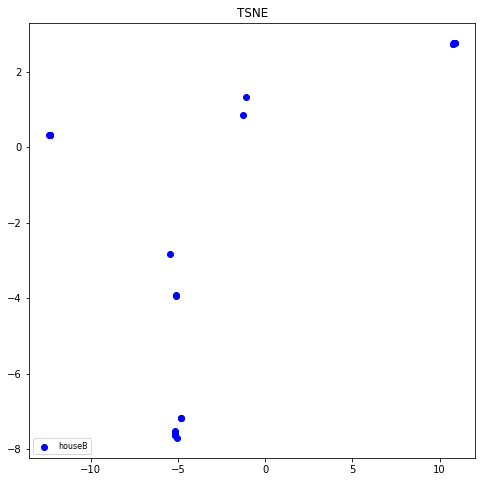

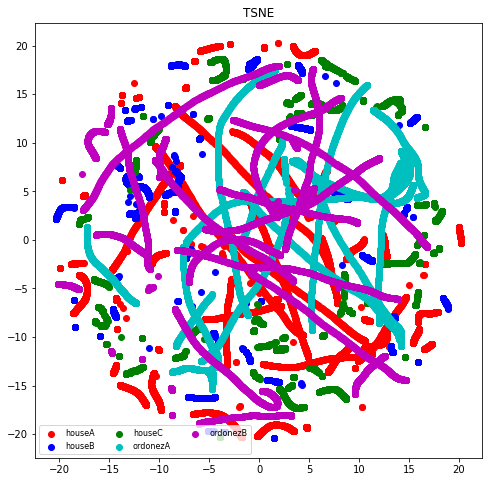

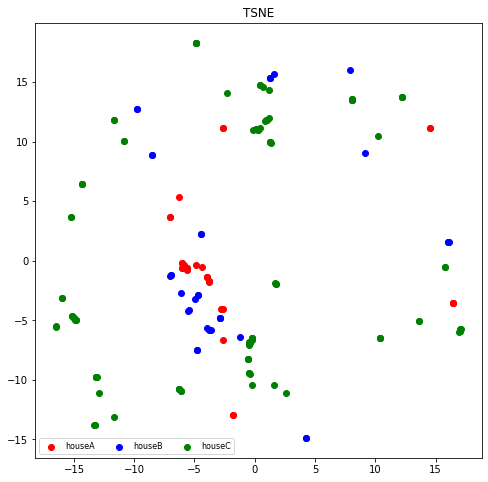

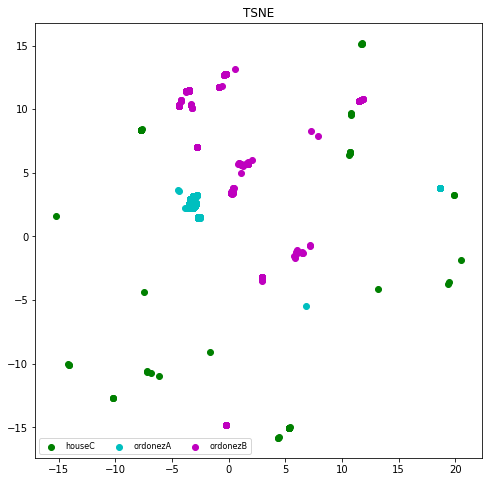

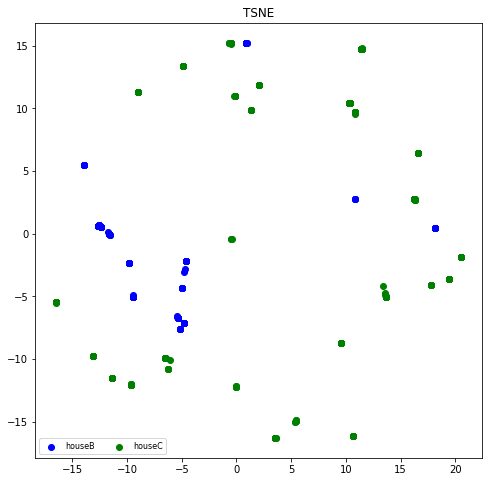

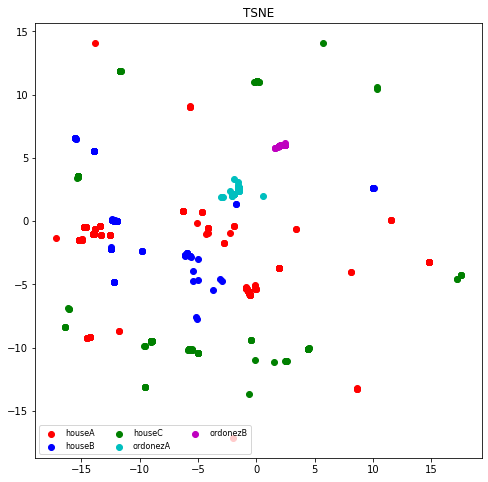

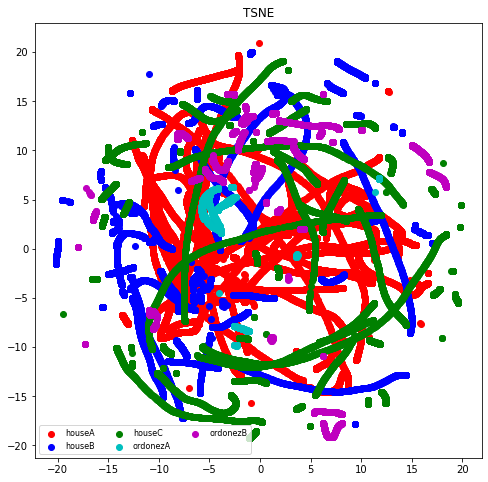

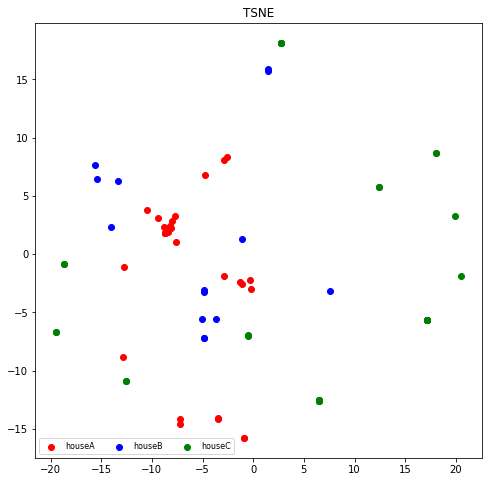

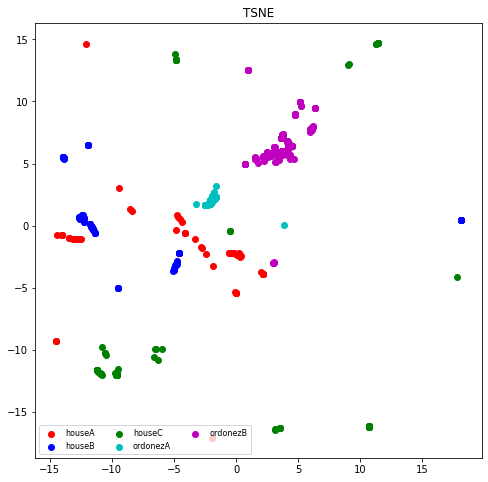

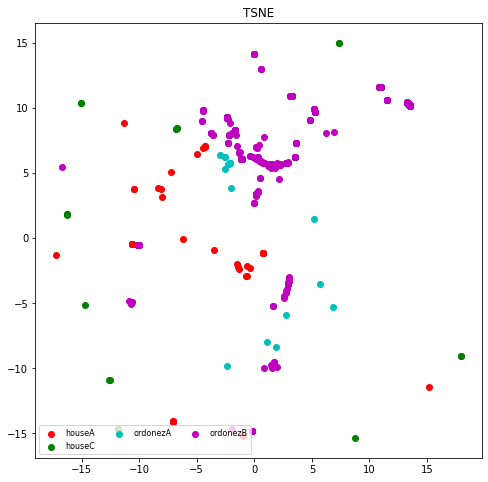

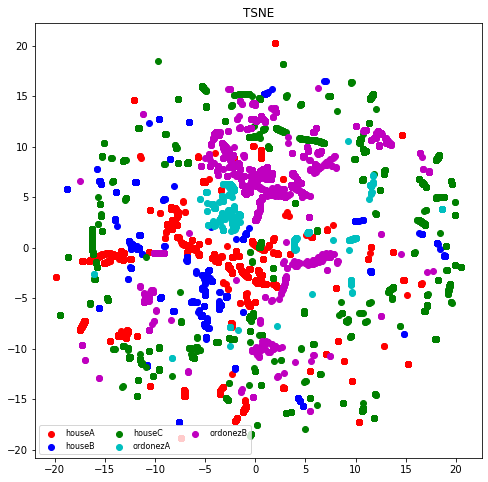

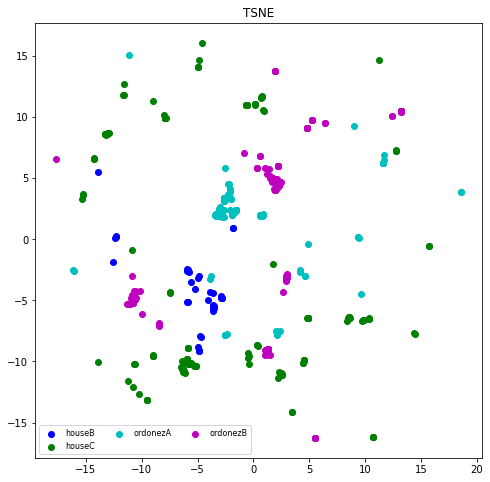

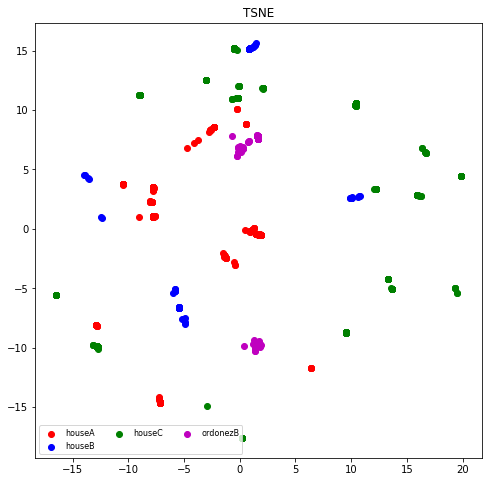

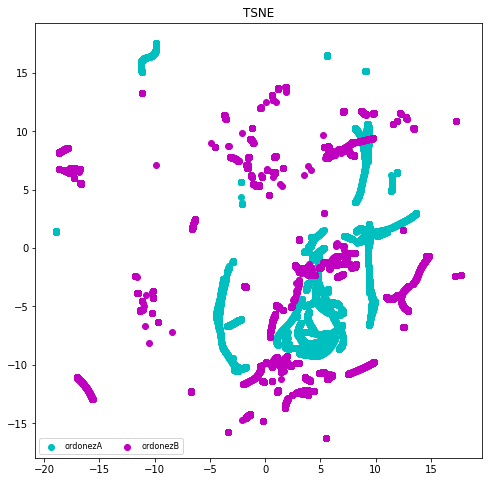

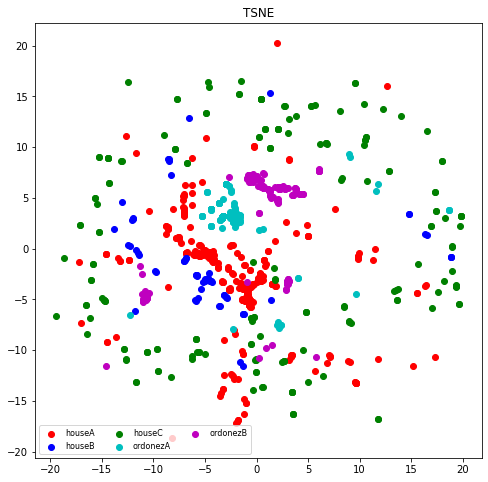

In [42]:
# Get index of each class and use only those index while plotting.
for i in range(num_classes):    
    # Create the figure
    fig = plt.figure( figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1, title='TSNE')
    
    houseA, houseB, houseC, ordonezA, ordonezB = [],[],[],[],[]
    
    # Create the scatter
    for j in activity_index_list[i]:
        if start[0] < j < end[0]:
            ordonezB.append(j)
        elif start[1] < j < end[1]:
            houseB.append(j)
        elif start[2] < j < end[2]:
            houseC.append(j)
        elif start[3] < j < end[3]:
            houseA.append(j)
        elif start[4] < j < end[4]:
            ordonezA.append(j)
              
    
    if houseA:
        houseA = ax.scatter(x=tsne_results[houseA,0], 
                   y=tsne_results[houseA,1],
                   color='r')
    if houseB:
        houseB = ax.scatter(x=tsne_results[houseB,0], 
                   y=tsne_results[houseB,1],
                   color='b')
    if houseC:
        houseC = ax.scatter(x=tsne_results[houseC,0], 
                   y=tsne_results[houseC,1],
                   color='g')
    if ordonezA:
        ordonezA = ax.scatter(x=tsne_results[ordonezA,0], 
                   y=tsne_results[ordonezA,1],
               color='c')
    if ordonezB:
        ordonezB = ax.scatter(x=tsne_results[ordonezB,0], 
               y=tsne_results[ordonezB,1],
               color='m')

    plt.legend((houseA, houseB, houseC, ordonezA, ordonezB),
       ('houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB'),
       scatterpoints=1,
       loc='lower left',
       ncol=3,
       fontsize=8)
    
    axes = plt.gca()
    
#     axes.set_xlim(np.min(tsne_results[activity_index_list[i],0]) ,  np.max(tsne_results[activity_index_list[i],0]) )
#     axes.set_ylim( np.min(tsne_results[activity_index_list[i],1]) ,  np.max(tsne_results[activity_index_list[i],1]) )
    plt.savefig('./images/all_house/graph_embedding/graph_Embeddings_Train_TSNE_'+ getClassnameFromID(i))        

### Above process for master.csv

In [55]:
# Master
house = pd.read_csv('../../data/master/master.csv')

In [56]:
house.head()

,start,end,activity,time_of_the_day,BedPressureRight,BasinBathroomPIR,ToiletFlushSensor,ShowerBathroomPIR,FridgeMagnetic,GroceriesCupboard,...,BathroomDoorMagnetic,PlatesCupboard_2_Magnetic,BedroomDresserPIR,BathroomSinkFloat,BathroomDoorPIR,CupsCupboardMagnetic,DishwasherApplianceStatusSensor,WashingmachineApplianceStatusSensor,CabinetMagneticBathroom,CooktopPIRKitchen
0,11-Nov-2012 21:14:00,11-Nov-2012 21:14:59,relaxing,0.884722,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,11-Nov-2012 21:15:00,11-Nov-2012 21:15:59,relaxing,0.885417,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,11-Nov-2012 21:16:00,11-Nov-2012 21:16:59,relaxing,0.886111,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,11-Nov-2012 21:17:00,11-Nov-2012 21:17:59,relaxing,0.886806,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,11-Nov-2012 21:18:00,11-Nov-2012 21:18:59,relaxing,0.887500,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [57]:
#master

import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn.manifold import TSNE


# df_labels = [x for x in house.loc[-1: , 'activity'].values]
activity_index_list = []
activity_index= []

num_classes = 15
for i in range(num_classes):    
    activity_index = house[house['activity'] == getClassnameFromID(i)].index.values
    activity_index_list.append(activity_index)

In [58]:
# Master

# df = house[house['activity'] == getClassnameFromID(i)]    
# Do not include start, end, activity..
house = house.iloc[:, 4:]    

time_start = time.time()
tsne = TSNE(n_iter=500)
tsne_results = tsne.fit_transform(house.values)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 523.928405046463 seconds


In [59]:
houseA = pd.read_csv('../../data/houseA/houseA.csv')
houseB = pd.read_csv('../../data/houseB/houseB.csv')
houseC = pd.read_csv('../../data/houseC/houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ordonezB.csv')
start = []
end = []
# Graph embedding order
# 'houseA', 'houseB', 'houseC', 'ordonezA'
# allHouseList = [len(houseA), len(houseB),len(houseC), len(ordonezA)]
# 
#master
allHouseList =  [len(ordonezB), len(houseB), len(houseC),len(houseA), len(ordonezA)]

uniqueIndex = []

for i, houseDatasetLength in enumerate(allHouseList):
    if i == 0:
        start.append(0)
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((0, sum(allHouseList[:i + 1])))
    else:
        start.append((sum(allHouseList[:i])))
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((sum(allHouseList[:i]), sum(allHouseList[:i + 1])))

/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Legend does not support [] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


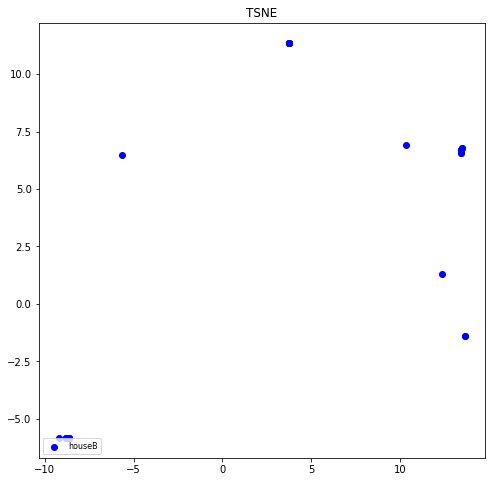

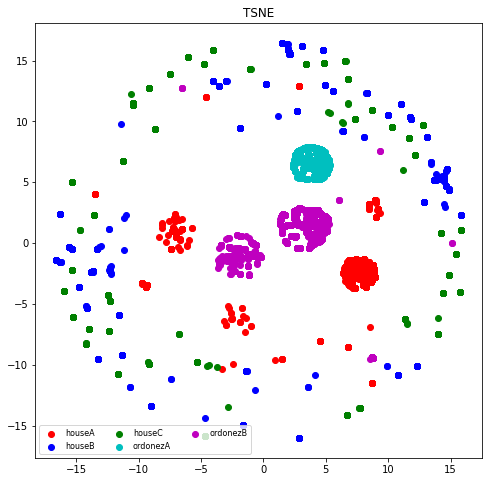

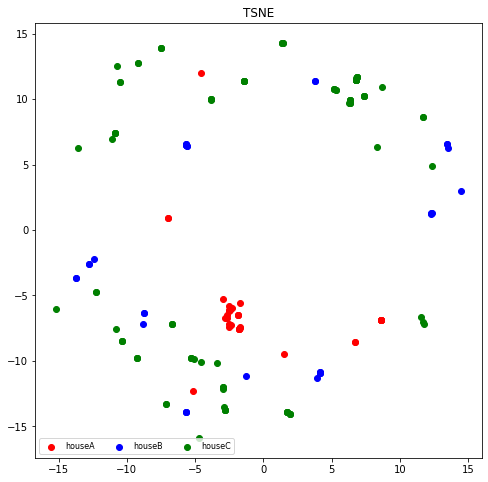

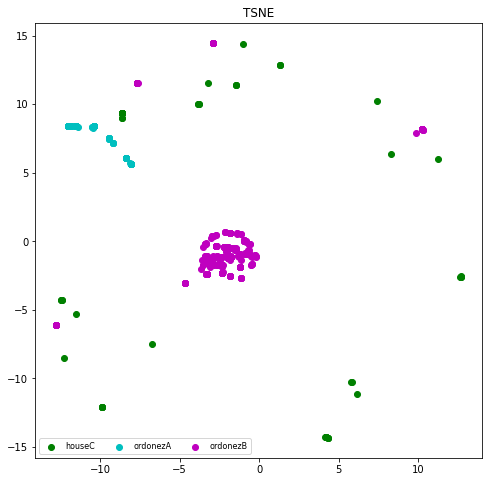

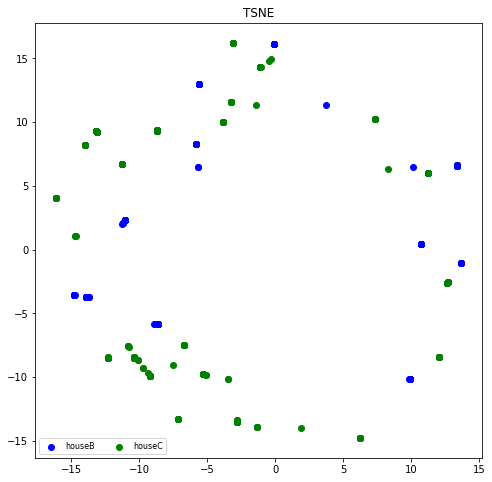

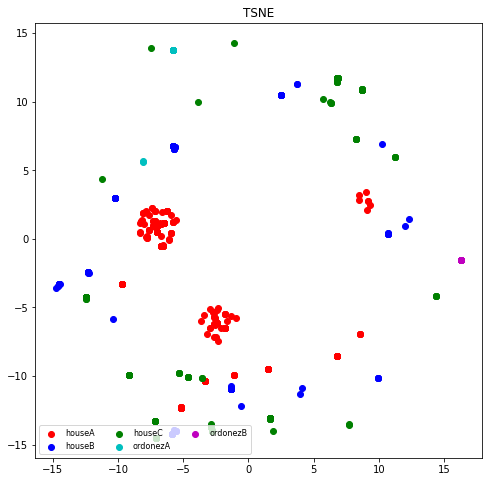

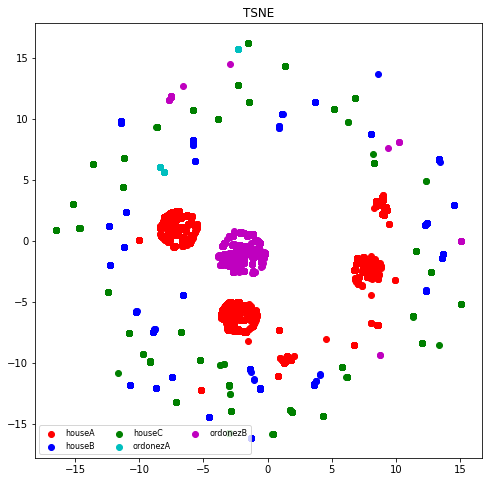

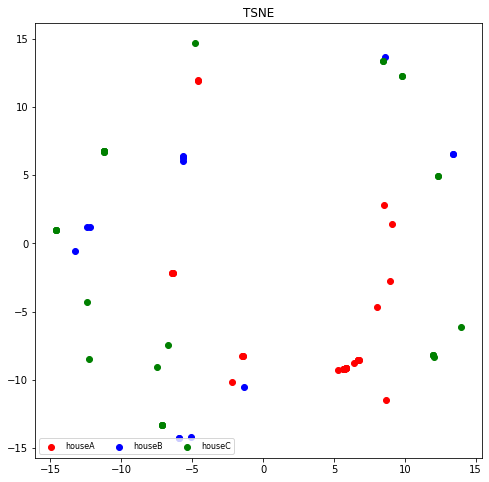

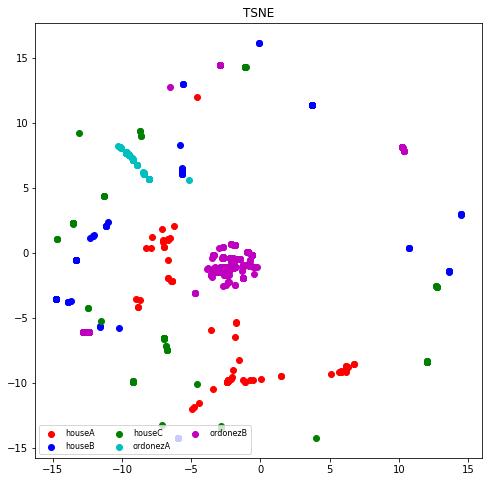

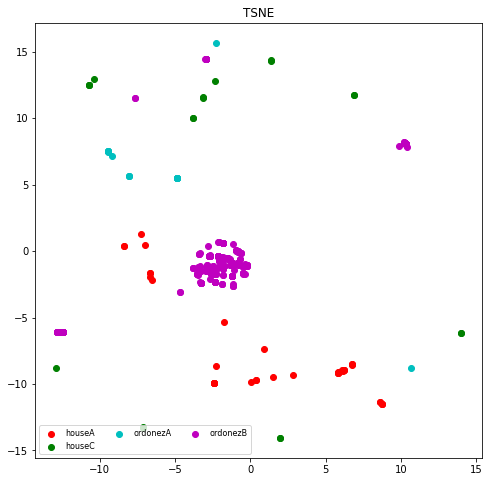

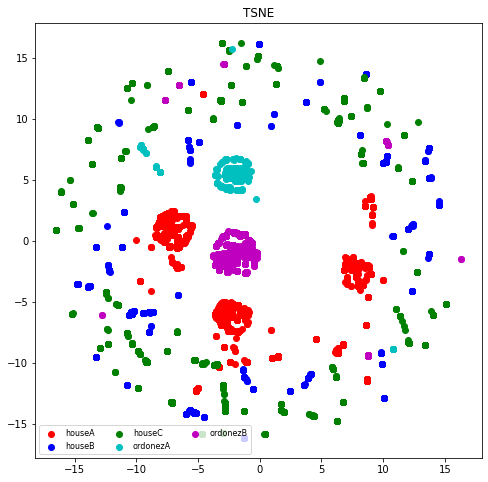

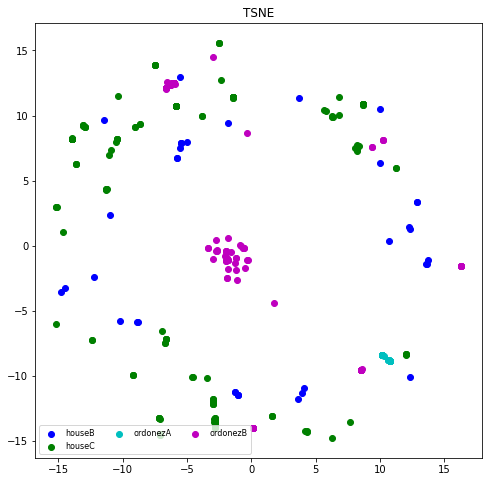

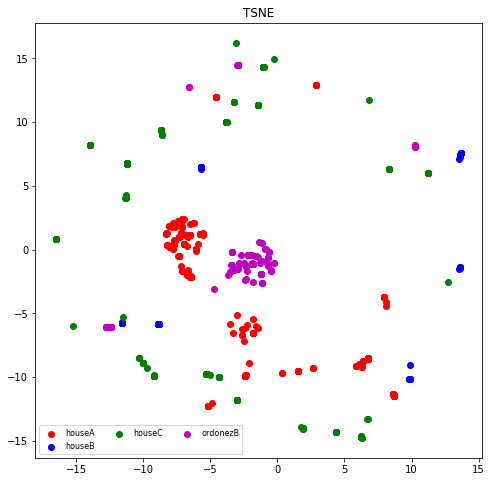

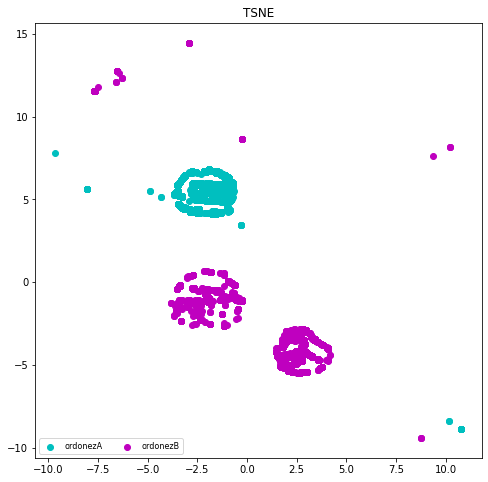

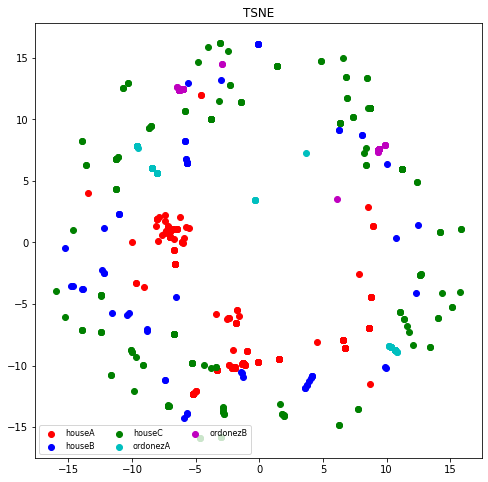

In [60]:
# Get index of each class and use only those index while plotting.
for i in range(num_classes):    
    # Create the figure
    fig = plt.figure( figsize=(8,8) )
    ax = fig.add_subplot(1, 1, 1, title='TSNE')
    
    houseA, houseB, houseC, ordonezA, ordonezB = [],[],[],[],[]
    
    # Create the scatter
    for j in activity_index_list[i]:
        if start[0] < j < end[0]:
            ordonezB.append(j)
        elif start[1] < j < end[1]:
            houseB.append(j)
        elif start[2] < j < end[2]:
            houseC.append(j)    
        elif start[3] < j < end[3]:
            houseA.append(j)      
        elif start[4] < j < end[4]:
            ordonezA.append(j)
              
    
    
    if houseA:
        houseA = ax.scatter(x=tsne_results[houseA,0], 
                   y=tsne_results[houseA,1],
                   color='r')
    if houseB:
        houseB = ax.scatter(x=tsne_results[houseB,0], 
                   y=tsne_results[houseB,1],
                   color='b')
    if houseC:
        houseC = ax.scatter(x=tsne_results[houseC,0], 
                   y=tsne_results[houseC,1],
                   color='g')
    if ordonezA:
        ordonezA = ax.scatter(x=tsne_results[ordonezA,0], 
                   y=tsne_results[ordonezA,1],
               color='c')
    if ordonezB:
        ordonezB = ax.scatter(x=tsne_results[ordonezB,0], 
               y=tsne_results[ordonezB,1],
               color='m')

    plt.legend((houseA, houseB, houseC, ordonezA, ordonezB),
       ('houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB'),
       scatterpoints=1,
       loc='lower left',
       ncol=3,
       fontsize=8)
    axes = plt.gca()
    
#     axes.set_xlim(np.min(tsne_results[activity_index_list[i],0]) ,  np.max(tsne_results[activity_index_list[i],0]) )
#     axes.set_ylim( np.min(tsne_results[activity_index_list[i],1]) ,  np.max(tsne_results[activity_index_list[i],1]) )
    plt.savefig('./images/all_house/master/'+ getClassnameFromID(i))            

# T-SNE for single house

In [65]:
house = pd.read_csv('../../../../Research/data/all_houses/all_house_raw_graph_embedding.csv')

# house_columns = house.columns
# norm = MinMaxScaler().fit(house.iloc[:, :-1])
# house.iloc[:, :-1] = norm.transform(house.iloc[:, :-1])


#!/usr/bin/env python
config = {
"learning_rate" : 0.0001,
"num_epochs" : 150,
"decay" : 1e-5,
"input_dim" : 48,
"hidden_dim" : 64,
"layer_dim" : 1,
"output_dim" : 16,
"seq_dim" : 2,
"batch_size" :8,
"split_ratio" : 0.5,
"num_workers":4,
"accumulation_steps": 1,
"no_of_subset":30 ,
"subset_overlap_length": 2 ,
"resize_width": 120,
"resize_height": 97,
"image_width": 663,
"image_height": 446,
"ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},        
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

"merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": "grooming",
        "shave": "grooming",
        "takeMedication": "idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "idle",
        "Respirate": "relaxing",
        "Work": "idle",
        "Housekeeping": "idle",
        "Idle": "idle",
        "watchTV": "relaxing"
    },
 "ob_representation": False,
 "leaveOneHouseOut": True
}



house = pd.read_csv('../../../../Research/data/houseA/houseA.csv')

house['activity'] = house['activity'].map(config['merging_activties']).fillna(
        house['activity'])


In [66]:
house.head()

,start,end,activity,time_of_the_day,Microwave_1,Hall-ToiletDoor_5,Hall-BathroomDoor_6,CupsCupboard_7,Fridge_8,PlatesCupboard_9,Frontdoor_12,Dishwasher_13,ToiletFlush_14,Freezer_17,PansCupboard_18,Washingmachine_20,GroceriesCupboard_23,Hall-BedroomDoor_24,last_fired_sensor
0,25-Feb-2008 00:19:00,25-Feb-2008 00:19:59,brushTeeth,0.013194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,25-Feb-2008 00:20:00,25-Feb-2008 00:20:59,brushTeeth,0.013889,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0
2,25-Feb-2008 00:21:00,25-Feb-2008 00:21:59,brushTeeth,0.014583,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0
3,25-Feb-2008 00:22:00,25-Feb-2008 00:22:59,goToBed,0.015278,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0
4,25-Feb-2008 00:23:00,25-Feb-2008 00:23:59,goToBed,0.015972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [67]:

import matplotlib.pyplot as plt
%matplotlib inline
import time

from sklearn.manifold import TSNE


df_labels = [x for x in house.loc[-1: , 'activity'].values]
activity_index_list = []
activity_index= []

num_classes = 15
for i in range(num_classes):    
    activity_index = house[house['activity'] == getClassnameFromID(i)].index.values
    activity_index_list.append(activity_index)

In [68]:
activity_index_list

[array([], dtype=int64),
 array([    3,     4,     5, ..., 37064, 37065, 37066]),
 array([    0,     1,     2,  1383,  1384,  1385,  2800,  2801,  4309,
         4310,  4311,  5430,  5431,  5432,  5702,  5703,  9856,  9857,
        12049, 12050, 12609, 12610, 12959, 12960, 14351, 14352, 15775,
        15776, 15777, 31711, 33143, 33144, 34413, 34414, 35977, 35978]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([  583,   584,   585,   586,   587,   588,   589,   590,   591,
          592,   593,  2009,  2010,  2011,  2012,  2013,  2014,  2015,
         2016,  2017,  2018,  2019,  3358,  3359,  3360,  3361,  3362,
         3363,  3364,  3365,  3366,  3367,  3368,  4939,  4940,  4941,
         4942,  4943,  4944,  4945,  4946,  4947,  4948,  4949,  4950,
         6372,  6373,  6374,  6375,  6376,  6377,  6378,  6379,  6380,
         6381, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625,
        10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 13526,
        13527,

In [69]:


# df = house[house['activity'] == getClassnameFromID(i)]    
# Do not include start, end, activity..
house = house.iloc[:, 4:]    

time_start = time.time()
tsne = TSNE(n_iter=250)
tsne_results = tsne.fit_transform(house.values)
print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 84.09815263748169 seconds


In [72]:
houseA = pd.read_csv('../../data/houseA/houseA.csv')
houseB = pd.read_csv('../../data/houseB/houseB.csv')
houseC = pd.read_csv('../../data/houseC/houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ordonezB.csv')
start = []
end = []
# Graph embedding order
# 'houseA', 'houseB', 'houseC', 'ordonezA'
# allHouseList = [len(houseA), len(houseB),len(houseC), len(ordonezA)]
# 
#master
allHouseList =  [len(ordonezB), len(houseB), len(houseC),len(houseA), len(ordonezA)]

uniqueIndex = []

for i, houseDatasetLength in enumerate(allHouseList):
    if i == 0:
        start.append(0)
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((0, sum(allHouseList[:i + 1])))
    else:
        start.append((sum(allHouseList[:i])))
        end.append(sum(allHouseList[:i + 1]))
#         uniqueIndex.append((sum(allHouseList[:i]), sum(allHouseList[:i + 1])))

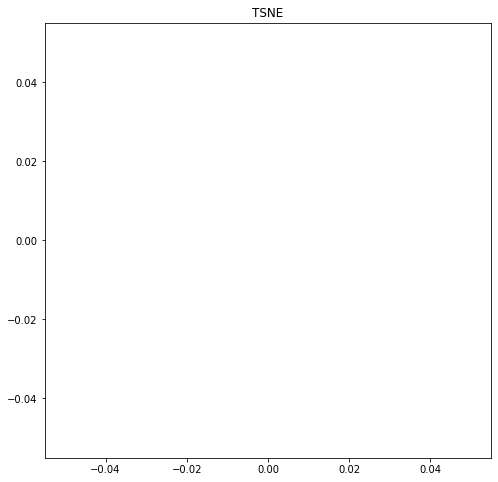

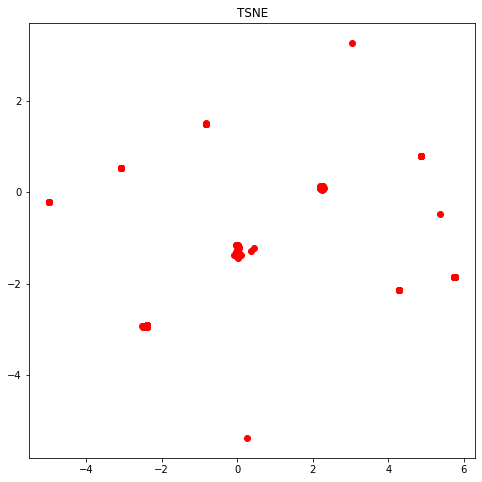

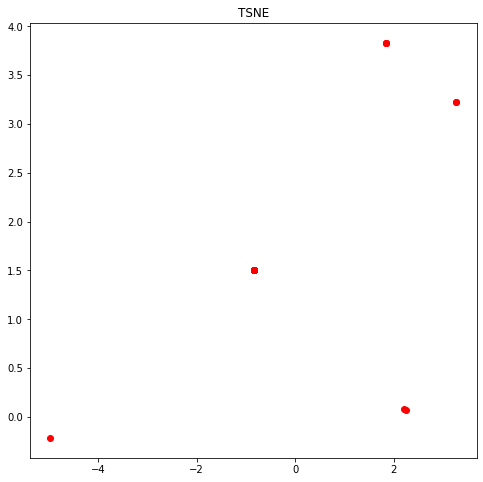

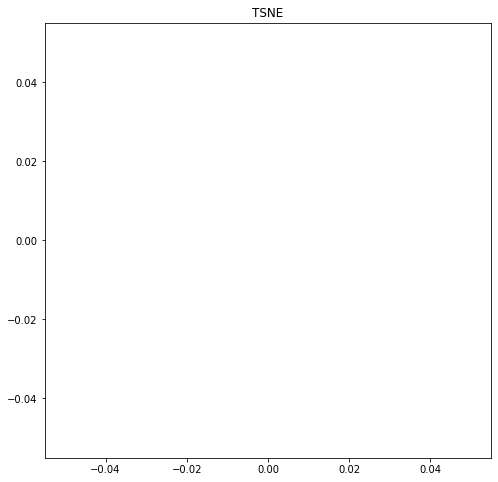

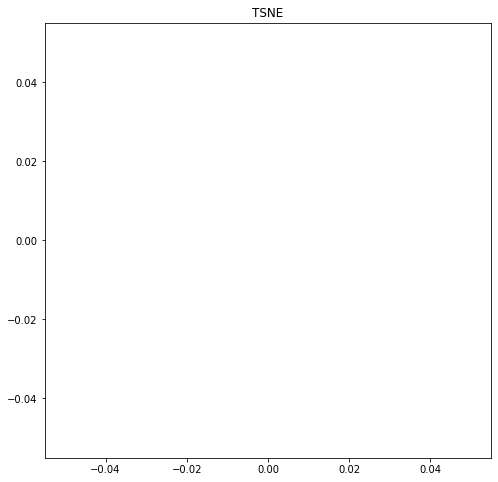

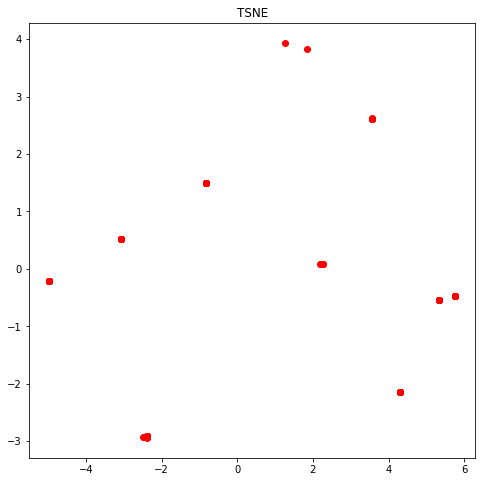

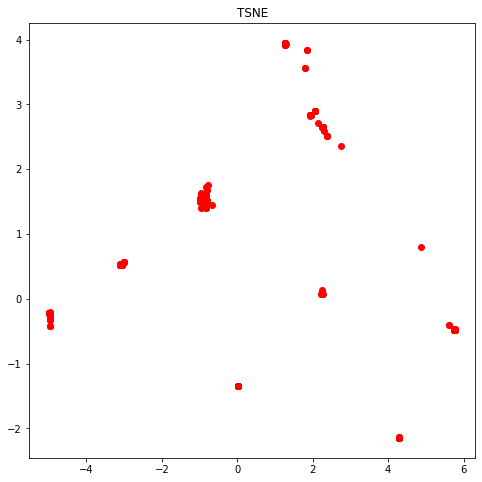

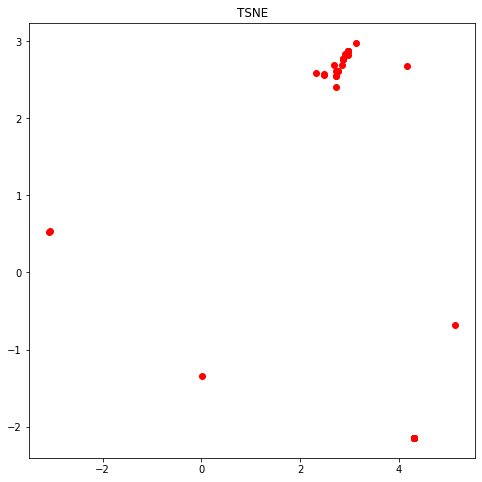

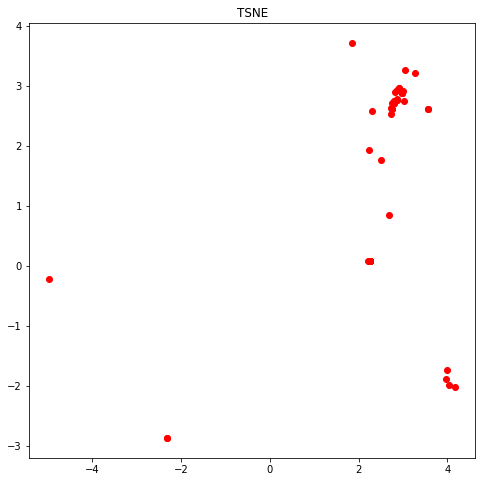

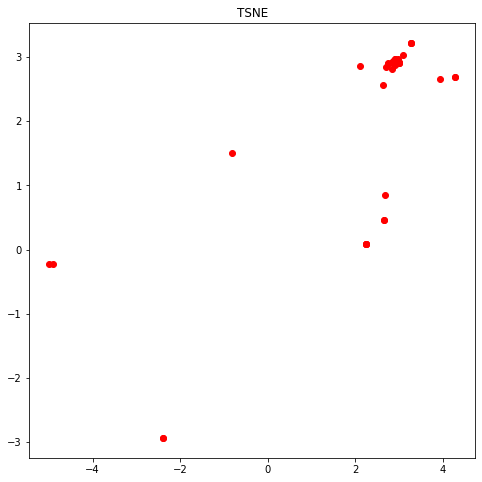

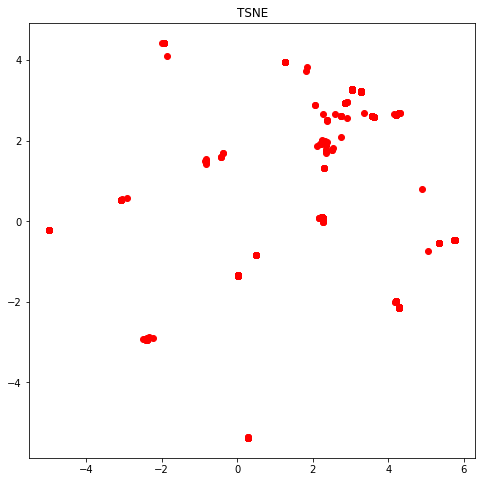

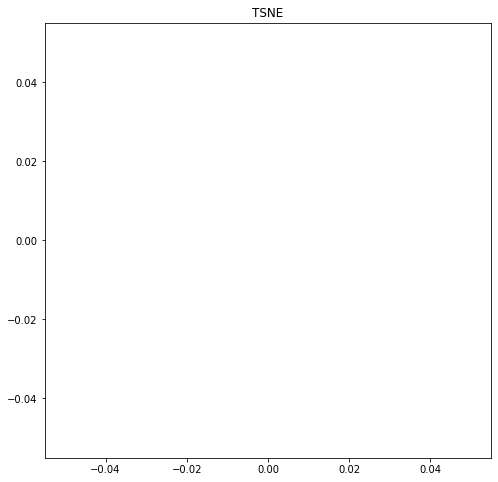

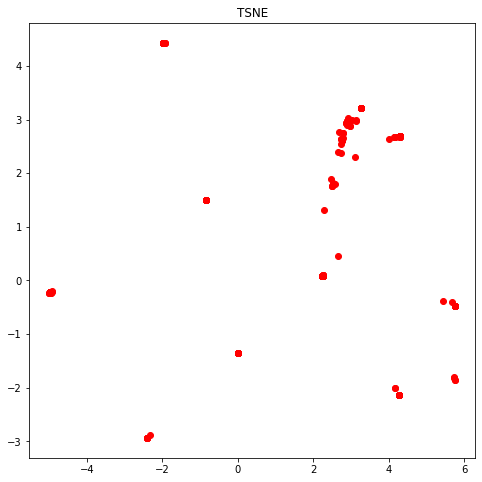

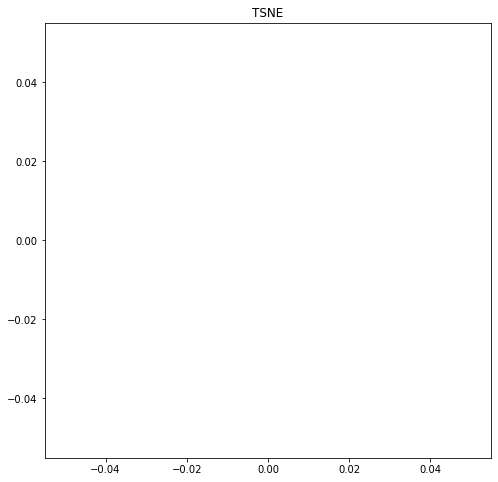

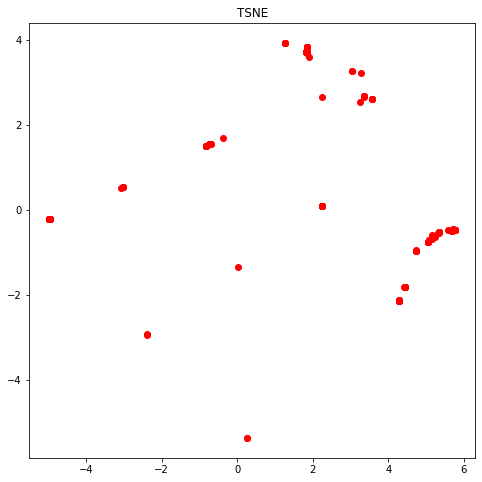

In [79]:
# Get index of each class and use only those index while plotting.
for i in range(num_classes):    
    # Create the figure
    fig = plt.figure( figsize=(8,8) )
    ax = fig.add_subplot(1, 1, 1, title='TSNE')
    
    houseA, houseB, houseC, ordonezA, ordonezB = [],[],[],[],[]
    
    # Create the scatter
    for j in activity_index_list[i]:
        if start[0] < j < end[0]:
            ordonezB.append(j)
        
        
  
    houseA = ax.scatter(x=tsne_results[ordonezB,0], 
                   y=tsne_results[ordonezB,1],
                   color='r')
 

    
    if activity_index_list is not None:
#         axes.set_xlim(np.min(tsne_results[activity_index_list[i],0]) ,  np.max(tsne_results[activity_index_list[i],0]) )
#         axes.set_ylim( np.min(tsne_results[activity_index_list[i],1]) ,  np.max(tsne_results[activity_index_list[i],1]) )
        plt.savefig('./images/houseA/'+ getClassnameFromID(i))            

## T-SNE for mnist Using procedure as above, just to check. Seems correct

In [187]:
import torchvision.datasets as dset

In [191]:
train_set = dset.MNIST('./',train=True,  download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
data_loader = torch.utils.data.DataLoader(
  
  datasets.MNIST('./', train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.5,), (0.5,))

In [196]:
x_train = []
y_train = []
for i in range(len(train_set)):
    x, y = train_set[i]
    x_train.append(x)
    y_train.append(y)

In [206]:
X = np.zeros((len(x_train), 784))

In [207]:
for i in range(len(train_set)):
    data = np.asarray(x_train[i], dtype="int32")

    X[i] = data.flatten()
    
X = pd.DataFrame(X)


In [208]:
X.shape


(60000, 784)

In [209]:
Y = pd.DataFrame(y_train)

In [210]:
Y.head()

,0
0,5
1,0
2,4
3,1
4,9


In [211]:
X = X.sample(frac=0.1, random_state=10).reset_index(drop=True)
Y = Y.sample(frac=0.1, random_state=10).reset_index(drop=True)
df = X


In [212]:
import time

from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 132.3494770526886 seconds


In [213]:
df['label'] = Y

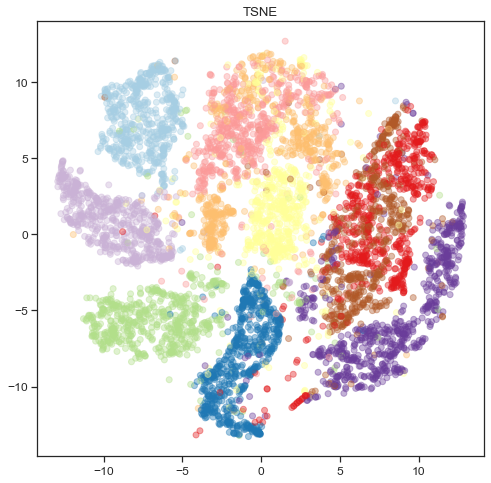

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline
# Create the figure
fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# Create the scatter
ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.4)
plt.savefig('./images/MNIST_TSNE')

# config

In [61]:
#!/usr/bin/env python
config = {
"learning_rate" : 0.0001,
"num_epochs" : 150,
"decay" : 1e-5,
"input_dim" : 79,
"hidden_dim" : 64,
"layer_dim" : 1,
"output_dim" : 16,
"seq_dim" : 2,
"batch_size" :8,
"split_ratio" : 0.5,
"num_workers":4,
"accumulation_steps": 1,
"no_of_subset":30 ,
"subset_overlap_length": 2 ,
"resize_width": 120,
"resize_height": 97,
"image_width": 663,
"image_height": 446,
"ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': ' grooming', 'id': 13},
         {'name': 'relaxing', 'id': 14},
         {'name': 'useToilet', 'id': 15}],

"merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "idle",
        "Respirate": "relaxing",
        "Work": "idle",
        "Housekeeping": "idle",
        "Idle": "idle",
        "watchTV": "relaxing"
    },
 "ob_representation": True
}

# Making Sensor change time CSV for Both raw and ob. Which tells for each sensor the time it was last changed

In [37]:
import dgl
import numpy as np
import torch
import pandas as pd
import json
from torch.utils.data import DataLoader
import torch.nn as nn
import dgl.nn.pytorch as dglnn
import torch.nn.functional as F
import os
from sklearn.preprocessing import MinMaxScaler

Using backend: pytorch


In [39]:
file_names = ['houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB']
# for conf in ['raw', 'ob']:
for conf in ['raw']:
    for file_name in file_names:
        print(conf + ' '+ file_name)
        
        if conf is 'raw':
            csv_file = os.path.join('../../data/', file_name,  file_name + '.csv')
        elif conf is 'ob':
            csv_file = os.path.join('../../data/', file_name, 'ob_' + file_name + '.csv')
            
        house = pd.read_csv(csv_file)
        if 'time_of_the_day' not in house:
            df_time = pd.to_datetime(house['start'])
            df_time = (df_time.dt.hour*60+df_time.dt.minute) * 60 + df_time.dt.second
            df_time/= 24 * 60 * 60
            house['time_of_the_day'] = df_time
            house.to_csv(csv_file, index=False)

        sensorTime = house.copy()

        ### Creating Sensor Timings CSV


        length_of_sensor_columns = len(house.iloc[0, 4:])
        print(length_of_sensor_columns)

        prev_value_of_sensor_row_list = np.zeros(length_of_sensor_columns, dtype=int)
        for i in range(1,len(house)):        
            for j in range(length_of_sensor_columns):        
                prev_sensor_value = house.iloc[prev_value_of_sensor_row_list[j], 4+j]
                current_sensor_value = house.iloc[i, 4+j]

                prev_sensor_time_of_day = house.loc[prev_value_of_sensor_row_list[j], 'time_of_the_day']        
                curr_sensor_time_of_day = house.loc[i, 'time_of_the_day']
                diff = abs(curr_sensor_time_of_day - prev_sensor_time_of_day) * 24    
                sensorTime.iloc[i, 4 + j] =  diff

                if prev_sensor_value != current_sensor_value:       
                    prev_value_of_sensor_row_list[j] = i

        # Normalize each column value b/w 0 to 1

        sensorTimeTemp = sensorTime.copy()

    #     house_columns = house.columns
        norm = MinMaxScaler().fit(sensorTime.iloc[:, 3:])
        sensorTime.iloc[:, 3:] = norm.transform(sensorTime.iloc[:, 3:])

    #     lastCol = house_temp.iloc[:, -1]
    #     house = pd.concat([pd.DataFrame(house), lastCol], axis = 1)
             
        if conf is 'raw':  
            sensorTime.to_csv(os.path.join('../../data/', file_name, 'house-sensorChangeTime.csv'), index = False)
            sensorTime.to_csv(os.path.join('../../../../Research/data', file_name, 'house-sensorChangeTime.csv'), index = False)
        elif conf is 'ob':
            sensorTime.to_csv(os.path.join('../../data/', file_name, 'ob-house-sensorChangeTime.csv'), index = False)
            sensorTime.to_csv(os.path.join('../../../../Research/data', file_name, 'ob-house-sensorChangeTime.csv'), index = False)

raw houseA
14
raw houseB
22
raw houseC
23
raw ordonezA
12
raw ordonezB
12


### KL Divergence for selecting best validation days from each of 4 house( as per the master_ob.csv Index)

In [10]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
import datetime
from datetime import datetime
import collections

In [11]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [15]:
houseA = pd.read_csv('../../data/houseA/houseA.csv')
houseB = pd.read_csv('../../data/houseB/houseB.csv')
houseC = pd.read_csv('../../data/houseC/houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ordonezB.csv')
masterOb =  pd.read_csv('../../data/master/master.csv')
start = []
end = []
# Graph embedding order
# 'houseA', 'houseB', 'houseC', 'ordonezA'

In [16]:
def getUniqueStartIndex(df1): 
    df = df1.copy()
    # this line converts the string object in Timestamp object
    if isinstance(df['start'][0], str):
        df['start'] = [datetime.strptime(d, '%d-%b-%Y %H:%M:%S') for d in df["start"]]
    # extracting date from timestamp
    if isinstance(df['start'][0], datetime):
        df['start'] = [datetime.date(d) for d in df['start']]
    s = df['start']
    return s[s.diff().dt.days != 0].index.values

In [17]:
FMT = '%d-%b-%Y %H:%M:%S'

house_list = [ordonezB, houseB ,houseC,houseA, ordonezA]

h_name_list = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
house_start_end_dict = {}
for house_no, df in enumerate(house_list):
    uniqueIndex = getUniqueStartIndex(df)
    start_end_list = []
    kl_div = []
    individual_house_index_list = []

    house_dict = df['activity'].groupby(df['activity']).count().to_dict()

    for i in range(len(uniqueIndex) - 1):
        start, end  = uniqueIndex[i], uniqueIndex[i + 1]    
        testing_dict =  df['activity'].groupby(df[start:end]['activity']).count().to_dict()

        for key, value in house_dict.items():
            if key not in testing_dict:
                testing_dict[key] = 1

        testing_values = list(testing_dict.values())
        testing_total = end - start
        testing_distribution = testing_values/testing_total

        training_index = np.append(np.arange(0,start), np.arange(end, len(df['activity'])))
        training_dict =  df['activity'].groupby(df.iloc[training_index]['activity']).count().to_dict()

        for key, value in house_dict.items():            
            if key not in training_dict:
                training_dict[key] = 1

        training_values = list(training_dict.values())
        training_total = end - start
        training_distribution = training_values/training_total
        
        kl_div.append(kl_divergence(testing_distribution, training_distribution))
        
        individual_house_index_list.append((start, end))
        
        start = masterOb[masterOb['start'] == house_list[house_no].loc[start, 'start']].index.values[0]
        end = masterOb[masterOb['end'] == house_list[house_no].loc[end, 'end']].index.values[0]
        start_end_list.append((start, end))
    
        

    min_value_index = kl_div.index(min(kl_div))
    print(h_name_list[house_no])
    print('master_OB_ csv Index: ',start_end_list[min_value_index])
    print('Individual csv ob index',individual_house_index_list[min_value_index])
    print()
    house_start_end_dict[h_name_list[house_no]] = start_end_list[min_value_index]
    
    
print(house_start_end_dict)

ordonezB
master_OB_ csv Index:  (8806, 10246)
Individual csv ob index (8806, 10246)

houseB
master_OB_ csv Index:  (33784, 35224)
Individual csv ob index (3314, 4754)

houseC
master_OB_ csv Index:  (51052, 51123)
Individual csv ob index (0, 71)

houseA
master_OB_ csv Index:  (77539, 78960)
Individual csv ob index (0, 1421)

ordonezA
master_OB_ csv Index:  (114626, 115919)
Individual csv ob index (0, 1293)

{'ordonezB': (8806, 10246), 'houseB': (33784, 35224), 'houseC': (51052, 51123), 'houseA': (77539, 78960), 'ordonezA': (114626, 115919)}


## Each house csv length

In [54]:
import pandas as pd
houseA = pd.read_csv('../../data/houseA/houseA.csv')
houseB = pd.read_csv('../../data/houseB/houseB.csv')
houseC = pd.read_csv('../../data/houseC/houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ordonezB.csv')
allHouseList = [len(ordonezB), len(houseB), len(houseC), len(houseA), len(ordonezA)]
house_list = [ordonezB, houseB, houseC, houseA, ordonezA]
house_name_list = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
Decompressed_start_end_dict = {}

for i, name in enumerate(house_name_list):
    if i == 0:
        # start and end of compressed csv
        start = 0
        end = sum(allHouseList[:i + 1])
    else:
        # start and end of compressed csv
        start = sum(allHouseList[:i])
        end = sum(allHouseList[:i + 1])
        

    Decompressed_start_end_dict[name] = (start, end)

Decompressed_start_end_dict

{'ordonezB': (0, 30470),
 'houseB': (30470, 51052),
 'houseC': (51052, 77539),
 'houseA': (77539, 114626),
 'ordonezA': (114626, 134501)}

## OB csv length

In [25]:
import pandas as pd
houseA = pd.read_csv('../../data/houseA/ob_houseA.csv')
houseB = pd.read_csv('../../data/houseB/ob_houseB.csv')
houseC = pd.read_csv('../../data/houseC/ob_houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ob_ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ob_ordonezB.csv')
allHouseList = [len(ordonezB), len(houseB), len(houseC), len(houseA), len(ordonezA)]
house_list = [ordonezB, houseB, houseC, houseA, ordonezA]
house_name_list = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
Decompressed_start_end_dict = {}

for i, name in enumerate(house_name_list):
    if i == 0:
        # start and end of compressed csv
        start = 0
        end = sum(allHouseList[:i + 1])
    else:
        # start and end of compressed csv
        start = sum(allHouseList[:i])
        end = sum(allHouseList[:i + 1])
        

    Decompressed_start_end_dict[name] = (start, end)

Decompressed_start_end_dict

{'ordonezB': (0, 2487),
 'houseB': (2487, 4636),
 'houseC': (4636, 6954),
 'houseA': (6954, 7989),
 'ordonezA': (7989, 8557)}

#  Pre processing for graph embeddings before giving it to masterCSV LSTM code

In [12]:
config =  [ {'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}
        ]

d = {}

for dict_ in config:
    d[dict_['id']] = dict_['name']
    
print(d)

{0: 'washDishes', 1: 'goToBed', 2: 'brushTeeth', 3: 'prepareLunch', 4: 'eating', 5: 'takeShower', 6: 'leaveHouse', 7: 'getDrink', 8: 'prepareBreakfast', 9: 'getSnack', 10: 'idle', 11: 'grooming', 12: 'prepareDinner', 13: 'relaxing', 14: 'useToilet'}


In [239]:
master_seq_list = [188, 1, 1, 1, 18, 1, 2, 2, 2, 1, 62, 1, 1, 456, 1, 5, 2, 1, 2, 1, 4, 1, 1, 2, 1, 1, 1, 2, 1, 18, 1, 2, 3, 9, 2, 1, 1, 2, 4, 1, 1, 1, 4, 1, 16, 1, 1, 1, 2, 2, 9, 1, 1, 1, 1, 1, 7, 1, 1, 1, 2, 1, 3, 2, 1, 3, 1, 13, 1, 1, 19, 1, 1, 13, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 4, 4, 8, 4, 7, 1, 12, 1, 1, 10, 1, 2, 1, 4, 4, 4, 1, 3, 1, 15, 1, 18, 1, 8, 2, 1, 1, 1, 1, 1, 27, 1, 1, 7, 1, 6, 1, 1, 1, 1, 1, 28, 1, 10, 1, 45, 1, 1, 1, 18, 1, 1, 4, 1, 7, 1, 1, 62, 1, 4, 1, 1, 2, 1, 3, 1, 1, 1, 114, 1, 1, 1, 6, 1, 4, 1, 2, 1, 1, 78, 1, 1, 1, 1, 15, 1, 1, 39, 1, 1, 1, 1, 1, 6, 1, 1, 100, 1, 1, 1, 442, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 2, 2, 5, 4, 4, 2, 3, 3, 1, 4, 1, 10, 1, 17, 1, 1, 1, 1, 34, 1, 2, 1, 168, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 2, 1, 1, 8, 1, 2, 1, 6, 1, 1, 4, 1, 5, 1, 1, 1, 1, 1, 67, 1, 12, 1, 1, 1, 1, 1, 24, 1, 1, 1, 55, 1, 1, 1, 1, 1, 1, 1, 18, 2, 24, 1, 1, 1, 23, 1, 2, 1, 21, 1, 29, 1, 2, 2, 1, 2, 1, 1, 185, 1, 1, 1, 16, 1, 4, 1, 11, 1, 2, 1, 1, 1, 1, 3, 1, 1, 35, 1, 5, 1, 1, 1, 282, 1, 2, 1, 225, 1, 2, 1, 1, 1, 1, 2, 7, 1, 2, 2, 1, 74, 1, 1, 1, 6, 1, 7, 1, 4, 1, 1, 1, 1, 3, 1, 1, 8, 1, 1, 1, 16, 1, 1, 8, 1, 1, 6, 3, 3, 1, 3, 4, 2, 1, 1, 9, 1, 2, 6, 1, 12, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 84, 1, 1, 1, 1, 1, 2, 1, 79, 1, 1, 3, 1, 3, 1, 229, 1, 4, 2, 2, 3, 1, 1, 1, 7, 1, 1, 53, 2, 30, 1, 2, 2, 1, 1, 1, 1, 1, 1, 26, 1, 2, 1, 1, 47, 1, 1, 3, 1, 1, 53, 1, 1, 1, 1, 1, 28, 2, 2, 1, 70, 1, 1, 349, 1, 1, 5, 1, 1, 100, 1, 1, 1, 1, 4, 1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 1, 7, 3, 1, 1, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 54, 2, 1, 6, 1, 8, 2, 2, 1, 79, 1, 1, 2, 2, 1, 72, 1, 1, 1, 10, 1, 6, 1, 7, 1, 14, 1, 19, 1, 9, 1, 1, 5, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 255, 1, 1, 4, 2, 108, 1, 1, 14, 1, 3, 1, 1, 1, 1, 1, 1, 136, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 578, 1, 1, 1, 1, 2, 9, 1, 10, 4, 2, 4, 2, 3, 4, 1, 16, 1, 8, 1, 20, 1, 1, 42, 1, 1, 1, 1, 55, 1, 18, 1, 1, 6, 1, 1, 1, 1, 3, 1, 1, 1, 19, 2, 4, 1, 1, 9, 2, 1, 1, 1, 1, 5, 1, 1, 165, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 119, 1, 1, 1, 5, 9, 1, 63, 1, 23, 2, 6, 1, 1, 6, 1, 240, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 430, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 9, 1, 3, 1, 4, 3, 6, 2, 1, 5, 2, 2, 1, 86, 1, 1, 3, 1, 6, 2, 5, 1, 1, 9, 1, 1, 82, 1, 1, 21, 1, 1, 5, 1, 1, 2, 1, 101, 1, 1, 4, 1, 1, 1, 55, 1, 1, 1, 1, 3, 1, 1, 2, 1, 20, 1, 36, 1, 22, 1, 1, 36, 1, 1, 1, 1, 1, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 21, 1, 1, 191, 1, 1, 2, 1, 3, 1, 54, 1, 4, 1, 437, 1, 1, 1, 5, 2, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 8, 10, 1, 4, 2, 1, 5, 1, 5, 1, 6, 1, 2, 1, 13, 1, 1, 5, 1, 1, 1, 1, 2, 1, 11, 1, 1, 3, 1, 220, 1, 2, 1, 1, 10, 1, 1, 1, 3, 3, 56, 1, 2, 1, 1, 1, 51, 1, 1, 21, 1, 5, 1, 4, 1, 2, 3, 1, 12, 2, 39, 1, 3, 2, 1, 1, 14, 1, 1, 1, 4, 46, 1, 3, 1, 4, 1, 2, 1, 1, 149, 1, 1, 1, 1, 2, 1, 5, 5, 3, 1, 16, 1, 1, 1, 1, 1, 1, 62, 1, 2, 1, 1, 1, 594, 1, 1, 1, 2, 1, 1, 3, 6, 1, 1, 7, 1, 1, 1, 51, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 5, 1, 1, 2, 6, 3, 2, 8, 2, 2, 1, 2, 5, 1, 4, 1, 4, 2, 1, 1, 1, 1, 1, 1, 105, 1, 1, 1, 1, 1, 80, 1, 1, 1, 1, 4, 5, 1, 1, 1, 1, 214, 1, 2, 2, 1, 1, 1, 4, 1, 1, 93, 1, 1, 27, 1, 1, 1, 1, 1, 1, 1, 2, 16, 1, 5, 1, 1, 1, 108, 1, 1, 1, 1, 57, 1, 2, 1, 1, 510, 1, 1, 1, 1, 1, 1, 11, 1, 1, 3, 2, 1, 2, 1, 5, 1, 2, 4, 1, 2, 9, 4, 6, 1, 1, 13, 1, 1, 1, 98, 1, 5, 2, 1, 2, 3, 1, 1, 4, 1, 4, 1, 7, 1, 4, 1, 4, 1, 31, 1, 13, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 17, 1, 1, 1, 13, 1, 30, 1, 1, 5, 2, 2, 1, 1, 1, 2, 1, 271, 1, 2, 1, 2, 1, 73, 1, 5, 1, 124, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 580, 1, 5, 1, 1, 1, 1, 3, 1, 1, 1, 82, 1, 3, 2, 8, 3, 1, 1, 3, 8, 1, 24, 1, 9, 1, 7, 1, 1, 41, 1, 1, 1, 1, 1, 3, 1, 5, 1, 1, 4, 1, 1, 9, 1, 1, 10, 1, 1, 49, 1, 1, 11, 1, 1, 6, 1, 1, 1, 7, 1, 20, 1, 1, 1, 1, 1, 111, 1, 1, 2, 1, 1, 1, 1, 69, 1, 6, 1, 1, 59, 1, 19, 1, 26, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 261, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 267, 1, 1, 1, 183, 41, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1, 2, 15, 1, 2, 1, 6, 1, 6, 1, 2, 1, 6, 1, 1, 1, 44, 1, 12, 1, 10, 12, 6, 1, 6, 1, 1, 18, 1, 11, 1, 97, 1, 1, 5, 1, 1, 1, 1, 1, 1, 18, 1, 1, 74, 1, 1, 7, 1, 1, 1, 80, 1, 1, 1, 1, 1, 1, 1, 121, 1, 1, 3, 1, 2, 1, 1, 1, 5, 1, 12, 1, 6, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 198, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 43, 1, 1, 1, 460, 25, 1, 3, 1, 1, 2, 1, 1, 3, 1, 5, 1, 1, 16, 1, 1, 9, 1, 3, 7, 4, 5, 1, 2, 1, 1, 1, 2, 1, 98, 1, 1, 1, 7, 1, 2, 1, 4, 1, 2, 1, 1, 5, 1, 1, 1, 52, 25, 1, 10, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 1, 116, 1, 1, 4, 1, 1, 1, 13, 1, 45, 1, 1, 1, 1, 1, 4, 1, 1, 102, 1, 2, 1, 129, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 128, 2, 1, 5, 1, 2, 565, 1, 1, 1, 1, 1, 4, 1, 2, 1, 3, 2, 1, 53, 1, 2, 1, 1, 1, 1, 2, 1, 6, 1, 9, 7, 5, 2, 1, 1, 1, 3, 2, 2, 3, 1, 1, 1, 1, 13, 1, 1, 1, 4, 1, 1, 46, 1, 1, 7, 1, 2, 1, 6, 1, 2, 1, 8, 1, 1, 1, 1, 2, 1, 36, 1, 2, 1, 1, 81, 1, 1, 1, 1, 1, 1, 233, 1, 1, 3, 4, 1, 1, 1, 22, 1, 68, 1, 1, 1, 11, 1, 3, 2, 1, 2, 14, 1, 1, 1, 61, 1, 1, 1, 80, 1, 3, 1, 59, 1, 1, 1, 453, 1, 4, 2, 1, 1, 1, 4, 1, 4, 1, 1, 10, 2, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 11, 1, 1, 18, 1, 1, 1, 1, 174, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 9, 38, 1, 1, 1, 1, 5, 3, 1, 1, 5, 1, 1, 1, 1, 46, 1, 1, 1, 6, 2, 1, 250, 1, 1, 1, 1, 2, 1, 105, 1, 7, 2, 2, 1, 1, 65, 1, 1, 1, 2, 1, 56, 1, 3, 1, 1, 60, 1, 1, 1, 1, 1, 435, 2, 1, 4, 1, 1, 44, 2, 1, 6, 2, 2, 1, 2, 1, 2, 4, 1, 3, 1, 19, 1, 5, 2, 1, 1, 4, 7, 3, 10, 4, 1, 1, 1, 2, 4, 1, 1, 1, 10, 1, 5, 1, 24, 1, 1, 1, 1, 1, 1, 22, 1, 1, 1, 2, 1, 18, 1, 1, 361, 1, 5, 2, 1, 5, 1, 1, 113, 1, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 248, 1, 2, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 508, 1, 5, 1, 1, 1, 1, 1, 7, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 57, 2, 3, 1, 3, 1, 1, 3, 1, 24, 1, 1, 1, 1, 55, 2, 1, 1, 1, 1, 4, 9, 13, 1, 2, 1, 5, 1, 6, 1, 23, 1, 2, 1, 1, 95, 1, 3, 1, 1, 1, 1, 1, 147, 1, 1, 1, 1, 1, 1, 14, 2, 24, 2, 6, 1, 1, 1, 1, 11, 60, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 264, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 442, 3, 1, 6, 2, 1, 1, 1, 1, 1, 13, 2, 1, 1, 2, 1, 7, 3, 2, 2, 2, 7, 1, 6, 1, 4, 1, 2, 1, 4, 1, 11, 1, 1, 2, 1, 1, 12, 1, 1, 82, 1, 1, 1, 1, 7, 1, 4, 1, 1, 12, 2, 4, 11, 1, 1, 1, 1, 1, 19, 1, 15, 1, 28, 1, 2, 1, 1, 1, 96, 1, 92, 1, 1, 6, 9, 1, 93, 1, 1, 3, 1, 1, 2, 1, 1, 5, 1, 2, 1, 145, 1, 1, 1, 1, 1, 1, 78, 1, 2, 1, 1, 1, 1, 3, 1, 5, 1, 1, 1, 1, 1, 1, 1, 57, 1, 1, 515, 1, 1, 1, 1, 2, 3, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 2, 1, 1, 6, 1, 6, 2, 1, 5, 1, 2, 2, 3, 1, 1, 3, 1, 2, 1, 173, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 17, 1, 6, 1, 1, 2, 1, 1, 1, 1, 1, 37, 1, 1, 1, 1, 23, 1, 7, 2, 1, 1, 1, 5, 1, 1, 18, 1, 1, 1, 1, 3, 1, 1, 116, 1, 1, 1, 1, 1, 1, 1, 11, 1, 8, 1, 1, 1, 51, 1, 81, 1, 1, 1, 1, 30, 1, 1, 7, 1, 2, 15, 1, 1, 6, 1, 1, 1, 15, 1, 1, 68, 1, 1, 1, 2, 1, 33, 1, 3, 1, 13, 1, 66, 1, 1, 1, 358, 1, 2, 1, 96, 60, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 1, 1, 8, 1, 2, 19, 2, 16, 1, 3, 1, 1, 4, 1, 1, 8, 1, 5, 4, 1, 2, 1, 21, 1, 4, 11, 2, 6, 1, 2, 1, 1, 1, 99, 1, 10, 1, 21, 1, 8, 1, 1, 2, 129, 1, 11, 1, 3, 2, 1, 2, 1, 152, 1, 1, 1, 105, 1, 7, 2, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 84, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 561, 1, 5, 1, 1, 1, 1, 1, 18, 1, 2, 6, 1, 4, 1, 3, 2, 2, 2, 1, 3, 7, 1, 4, 3, 1, 1, 1, 20, 1, 4, 1, 1, 2, 1, 4, 1, 5, 1, 1, 18, 1, 5, 1, 12, 1, 1, 1, 32, 1, 2, 2, 6, 1, 19, 1, 16, 1, 32, 1, 1, 19, 1, 1, 3, 1, 1, 1, 1, 1, 26, 1, 1, 16, 2, 1, 2, 1, 1, 1, 1, 1, 13, 1, 1, 3, 1, 1, 53, 1, 1, 2, 1, 1, 94, 1, 1, 15, 1, 1, 1, 2, 1, 1, 1, 103, 1, 8, 1, 14, 1, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 244, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 458, 1, 4, 1, 1, 49, 1, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 12, 1, 20, 1, 11, 1, 1, 1, 5, 1, 3, 1, 1, 14, 2, 1, 1, 1, 1, 2, 1, 3, 2, 1, 13, 1, 4, 1, 1, 31, 1, 1, 5, 1, 17, 1, 12, 1, 2, 1, 21, 1, 2, 1, 20, 1, 1, 1, 12, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 16, 1, 1, 1, 1, 9, 1, 1, 4, 1, 2, 1, 3, 1, 64, 1, 11, 1, 1, 1, 1, 6, 1, 2, 1, 94, 1, 1, 1, 1, 1, 7, 1, 8, 1, 3, 1, 1, 3, 1, 1, 46, 1, 1, 4, 1, 11, 1, 6, 1, 1, 9, 1, 1, 1, 36, 1, 225, 1, 20, 1, 1, 3, 1, 1, 1, 15, 1, 1, 17, 1, 4, 1, 9, 3, 1, 5, 1, 2, 2, 2, 1, 1, 7, 1, 2, 1, 1, 12, 1, 4, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 1, 8, 2, 29, 1, 2, 1, 1, 1, 1, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 3, 1, 1, 1, 7, 1, 8, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 12, 2, 10, 1, 2, 1, 18, 26, 1, 1, 5, 1, 11, 1, 3, 11, 3, 1, 11, 2, 59, 1, 19, 2, 1, 1, 65, 3, 2, 42, 1, 1, 1, 2, 5, 1, 1, 2, 2, 1, 1, 2, 4, 1, 1, 3, 22, 2, 24, 1, 1, 2, 1, 2, 57, 1, 3, 19, 3, 9, 1, 13, 1, 1, 1, 1, 19, 1, 1, 1, 4, 1, 3, 1, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 5, 8, 1, 1, 4, 1, 1, 1, 6, 2, 8, 1, 3, 1, 2, 2, 1, 7, 2, 14, 1, 2, 1, 2, 1, 3, 2, 12, 1, 1, 1, 12, 2, 1, 5, 1, 5, 1, 1, 1, 2, 1, 1, 6, 1, 8, 2, 2, 4, 1, 2, 1, 1, 3, 1, 11, 1, 3, 1, 1, 1, 6, 1, 2, 1, 1, 1, 5, 1, 2, 1, 2, 1, 1, 2, 1, 27, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 22, 1, 1, 1, 1, 4, 22, 1, 2, 10, 1, 2, 1, 9, 1, 6, 1, 8, 2, 6, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 8, 1, 3, 5, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 2, 1, 1, 5, 1, 1, 1, 34, 1, 6, 1, 1, 267, 133, 1, 335, 1, 1, 1, 1, 1, 1, 1, 245, 1, 16, 1, 252, 1, 1, 1, 1, 4, 2, 30, 2, 1, 41, 1, 2, 8, 18, 1, 3, 1, 1, 1, 1, 1, 1, 7, 2, 3, 19, 1, 54, 1, 7, 1, 1, 2, 1, 1, 2, 1, 1, 20, 1, 1, 356, 1, 7, 6, 3, 1, 6, 2, 1, 1, 9, 1, 91, 1, 20, 1, 6, 1, 72, 1, 19, 1, 21, 4, 32, 1, 35, 3, 11, 2, 41, 1, 1, 2, 1, 1, 6, 1, 2, 1, 3, 1, 67, 1, 33, 1, 75, 1, 35, 1, 11, 1, 7, 1, 4, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 5, 1, 6, 1, 2, 1, 1, 1, 16, 1, 1, 28, 1, 1, 4, 40, 6, 2, 1, 16, 1, 3, 1, 15, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 11, 1, 10, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 14, 1, 1, 1, 1, 219, 1, 25, 1, 45, 1, 17, 1, 17, 1, 199, 1, 20, 1, 32, 1, 17, 1, 1, 2, 2, 1, 2, 1, 1, 1, 5, 1, 6, 1, 1, 4, 7, 1, 5, 3, 1, 2, 30, 5, 2, 3, 1, 5, 4, 36, 1, 48, 3, 1, 35, 29, 12, 1, 42, 1, 12, 1, 20, 2, 32, 1, 6, 1, 7, 10, 1, 24, 1, 17, 1, 6, 2, 5, 1, 16, 1, 1, 1, 2, 1, 2, 1, 4, 7, 1, 5, 32, 7, 16, 4, 1, 1, 6, 1, 5, 1, 3, 5, 1, 3, 1, 11, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 2, 10, 1, 2, 1, 2, 3, 1, 1, 3, 1, 2, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 4, 1, 2, 3, 4, 1, 11, 1, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 21, 2, 1, 1, 6, 5, 7, 1, 3, 1, 1, 1, 1, 11, 1, 4, 12, 1, 1, 4, 10, 1, 10, 1, 21, 1, 135, 1, 26, 1, 5, 1, 49, 1, 20, 1, 45, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 2, 1, 14, 3, 10, 2, 7, 1, 5, 1, 6, 1, 6, 1, 2, 1, 1, 1, 1, 12, 15, 1, 1, 1, 9, 6, 2, 2, 1, 3, 12, 1, 17, 49, 4, 25, 3, 1, 3, 3, 1, 1, 1, 8, 2, 2, 1, 3, 1, 1, 2, 1, 1, 23, 8, 1, 6, 1, 3, 1, 2, 4, 2, 5, 3, 3, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 6, 1, 1, 2, 1, 3, 1, 4, 1, 7, 2, 10, 2, 7, 1, 1, 1, 5, 1, 1, 11, 8, 1, 30, 1, 24, 1, 3, 1, 9, 17, 25, 1, 7, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 62, 1, 2, 1, 1, 1, 8, 2, 5, 1, 1, 1, 1, 1, 49, 1, 14, 2, 1, 11, 1, 38, 3, 1, 1, 1, 2, 3, 14, 2, 1, 4, 5, 1, 3, 3, 1, 1, 1, 4, 9, 13, 4, 17, 22, 1, 2, 12, 1, 1, 7, 15, 1, 1, 1, 10, 1, 1, 1, 12, 1, 15, 1, 2, 1, 1, 1, 1, 1, 3, 6, 6, 1, 1, 1, 6, 1, 1, 2, 2, 2, 17, 1, 1, 1, 33, 1, 2, 1, 2, 1, 1, 16, 2, 1, 22, 3, 8, 2, 19, 1, 18, 1, 1, 1, 1, 6, 1, 4, 1, 3, 1, 1, 1, 1, 1, 9, 2, 1, 1, 1, 102, 1, 20, 2, 1, 2, 2, 1, 7, 1, 12, 1, 9, 1, 5, 1, 10, 1, 17, 3, 1, 3, 3, 1, 32, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 7, 1, 8, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 143, 1, 88, 1, 36, 1, 54, 1, 71, 2, 73, 1, 1, 1, 1, 2, 1, 1, 4, 3, 1, 44, 20, 63, 1, 52, 1, 47, 1, 16, 1, 47, 2, 9, 38, 2, 32, 2, 1, 18, 1, 3, 2, 13, 1, 1, 1, 5, 1, 1, 3, 5, 3, 14, 2, 4, 1, 1, 1, 6, 1, 6, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 2, 9, 1, 18, 1, 1, 1, 9, 1, 1, 1, 1, 1, 4, 2, 4, 1, 5, 1, 2, 17, 1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 1, 2, 1, 76, 1, 64, 1, 95, 1, 1, 1, 2, 155, 311, 1, 19, 2, 1, 1, 1, 2, 2, 1, 7, 1, 11, 54, 2, 3, 1, 1, 144, 1, 13, 2, 20, 1, 1, 25, 26, 5, 4, 7, 5, 4, 6, 2, 1, 1, 12, 1, 75, 4, 8, 8, 4, 1, 12, 1, 4, 11, 5, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 8, 1, 12, 1, 3, 1, 1, 10, 19, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 657, 1, 1, 1, 1, 2, 4, 3, 1, 1, 1, 1, 1, 10, 1, 8, 1, 65, 1, 10, 36, 26, 1, 7, 11, 6, 1, 1, 1, 6, 1, 1, 52, 1, 2, 12, 1, 38, 4, 68, 20, 1, 1, 1, 5, 1, 1, 1, 1, 58, 1, 91, 1, 14, 1, 13, 1, 35, 1, 12, 1, 12, 3, 1, 4, 1, 4, 1, 3, 3, 4, 1, 12, 1, 8, 21, 3, 3, 2, 2, 2, 1, 1, 1, 1, 5, 1, 6, 1, 16, 2, 1, 1, 1, 1, 4, 4, 10, 5, 1, 7, 2, 1, 1, 8, 1, 8, 1, 5, 2, 1, 2, 1, 20, 3, 1, 2, 6, 2, 2, 1, 466, 2, 52, 1, 14, 1, 15, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 1, 1, 1, 7, 1, 1, 14, 2, 38, 4, 1, 1, 4, 1, 9, 1, 3, 1, 5, 5, 1, 1, 2, 1, 1, 2, 9, 2, 1, 3, 1, 1, 1, 1, 3, 1, 44, 1, 12, 1, 19, 50, 1, 2, 27, 3, 2, 3, 9, 1, 69, 1, 1, 1, 1, 3, 1, 1, 1, 8, 1, 1, 48, 1, 1, 1, 2, 1, 1, 1, 206, 1, 1, 1, 1, 2, 1, 1, 1, 1, 9, 2, 1, 1, 1, 1, 1, 2, 1, 14, 18, 1, 1, 4, 1, 1, 1, 4, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 1, 224, 1, 1, 1, 1, 2, 1, 584, 1, 213, 1, 1, 16, 1, 2, 2, 2, 2, 1, 1, 9, 1, 1, 2, 35, 1, 1, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 290, 1, 27, 313, 287, 2, 39, 46, 586, 1, 410, 1, 1, 1, 1, 1, 1, 1, 3, 2, 7, 1, 6, 2, 1, 2, 1, 508, 1, 1, 1, 2, 1, 4, 13, 1, 1, 1, 9, 1, 6, 30, 1, 1, 1, 8, 1, 5, 2, 35, 1, 3, 2, 2, 18, 2, 19, 3, 9, 1, 1, 2, 1, 1, 7, 3, 1, 1, 1, 2, 17, 1, 4, 1, 5, 1, 1, 19, 2, 1, 33, 1, 2, 1, 22, 25, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 2, 1, 2, 1, 11, 3, 1, 1, 1, 1, 2, 1, 6, 2, 10, 2, 16, 1, 8, 1, 4, 1, 3, 19, 2, 9, 10, 12, 1, 1, 4, 1, 1, 1, 3, 8, 10, 6, 1, 1, 8, 3, 1, 3, 1, 19, 5, 7, 10, 1, 2, 11, 8, 1, 35, 1, 12, 1, 83, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 35, 1, 1, 3, 2, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 17, 5, 3, 2, 6, 1, 1, 1, 1, 1, 2, 117, 1, 1, 12, 1, 76, 2, 52, 1, 242, 1, 1, 1, 1, 3, 1, 8, 35, 2, 1, 1, 1, 1, 1, 1, 19, 2, 5, 2, 1, 1, 17, 13, 1, 156, 1, 30, 2, 5, 1, 1, 1, 14, 1, 1, 1, 1, 120, 1, 11, 2, 1, 24, 4, 2, 3, 1, 10, 1, 2, 98, 2, 64, 31, 1, 38, 1, 2, 1, 3, 1, 92, 6, 1, 1, 2, 2, 10, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 15, 3, 1, 16, 1, 1, 3, 1, 7, 12, 6, 1, 3, 2, 5, 3, 1, 1, 5, 1, 4, 1, 1, 1, 3, 1, 1, 235, 2, 120, 1, 74, 1, 6, 1, 5, 3, 3, 18, 9, 1, 3, 1, 18, 3, 8, 1, 3, 1, 5, 2, 1, 1, 4, 2, 2, 1, 13, 1, 13, 1, 3, 1, 43, 1, 2, 1, 3, 1, 9, 1, 16, 1, 5, 1, 30, 1, 31, 1, 21, 1, 1, 26, 17, 1, 20, 2, 75, 1, 5, 1, 4, 2, 4, 1, 24, 1, 25, 1, 12, 2, 8, 1, 3, 8, 3, 1, 1, 1, 4, 4, 12, 1, 6, 5, 8, 1, 5, 2, 26, 1, 14, 1, 1, 1, 18, 1, 27, 1, 1, 1, 63, 2, 14, 1, 6, 1, 6, 1, 1, 1, 8, 1, 9, 5, 4, 1, 1, 1, 12, 4, 3, 1, 5, 4, 18, 1, 6, 13, 6, 1, 2, 1, 2, 4, 22, 1, 4, 2, 1, 5, 6, 1, 1, 6, 4, 3, 1, 3, 3, 1, 6, 1, 6, 2, 4, 9, 6, 1, 3, 3, 2, 10, 2, 3, 3, 1, 11, 1, 4, 1, 1, 2, 1, 1, 1, 11, 7, 1, 6, 2, 3, 1, 1, 1, 2, 1, 1, 7, 10, 1, 2, 4, 1, 2, 1, 1, 7, 1, 8, 1, 4, 1, 1, 7, 9, 1, 13, 1, 4, 1, 1, 13, 2, 1, 4, 1, 2, 1, 3, 9, 1, 1, 3, 1, 1, 4, 1, 1, 4, 1, 1, 1, 2, 2, 1, 5, 4, 1, 1, 2, 7, 2, 1, 1, 27, 2, 11, 1, 13, 1, 3, 17, 1, 1, 8, 2, 2, 1, 1, 2, 12, 1, 2, 1, 1, 2, 7, 1, 2, 1, 1, 7, 2, 3, 14, 1, 16, 1, 27, 1, 5, 1, 10, 1, 12, 1, 13, 1, 8, 2, 1, 7, 2, 2, 15, 2, 2, 2, 51, 1, 1, 22, 1, 1, 22, 1, 4, 1, 21, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 11, 1, 2, 6, 34, 34, 1, 1, 17, 3, 1, 10, 1, 90, 9, 2, 1, 13, 1, 39, 2, 1, 5, 14, 7, 1, 2, 2, 4, 3, 1, 2, 1, 2, 17, 1, 9, 1, 1, 2, 9, 3, 4, 5, 1, 6, 34, 3, 1, 1, 1, 8, 1, 4, 1, 19, 1, 5, 2, 1, 1, 1, 4, 28, 11, 1, 13, 1, 8, 1, 2, 4, 4, 13, 10, 1, 1, 2, 112, 1, 1, 1, 3, 1, 1, 3, 1, 13, 7, 1, 219, 1, 4, 5, 1, 1, 3, 1, 3, 1, 1, 9, 2, 1, 3, 14, 1, 1, 3, 38, 5, 51, 1, 291, 1, 1, 1, 3, 1, 1, 1, 45, 25, 2, 3, 1, 9, 1, 7, 3, 2, 35, 1, 1, 19, 2, 1, 2, 18, 8, 20, 103, 1, 2, 1, 1, 2, 3, 9, 8, 1, 61, 231, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 85, 1, 34, 2, 2, 1, 1, 4, 1, 44, 65, 1, 1, 19, 1, 13, 7, 5, 1, 1, 1, 1, 1, 2, 1, 94, 1, 4, 2, 1, 2, 1, 1, 1, 1, 3, 46, 1, 7, 1, 1, 1, 14, 1, 101, 8, 1, 33, 1, 4, 1, 19, 1, 1, 30, 1, 20, 1, 23, 2, 69, 1, 28, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 2, 3, 1, 1, 2, 6, 7, 1, 2, 3, 1, 26, 1, 7, 1, 4, 25, 8, 11, 23, 1, 1, 1, 1, 2, 11, 1, 22, 1, 88, 2, 52, 1, 25, 1, 14, 2, 8, 1, 22, 1, 1, 2, 22, 1, 1, 1, 8, 1, 5, 1, 26, 1, 1, 2, 5, 1, 1, 1, 4, 1, 1, 22, 2, 2, 1, 1, 2, 2, 1, 10, 3, 2, 1, 1, 7, 99, 2, 1, 2, 17, 1, 3, 1, 274, 1, 1, 1, 2, 1, 11, 1, 9, 2, 3, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 4, 71, 2, 361, 7, 1, 2, 1, 2, 7, 2, 43, 4, 8, 1, 1, 2, 1, 7, 3, 1, 2, 2, 1, 4, 2, 2, 1, 3, 2, 1, 35, 12, 10, 1, 2, 1, 5, 23, 1, 1, 1, 1, 1, 6, 1, 1, 2, 37, 1, 7, 10, 1, 29, 13, 2, 1, 26, 4, 3, 11, 20, 1, 20, 11, 11, 1, 1, 1, 8, 4, 3, 1, 5, 1, 1, 1, 2, 2, 1, 1, 1, 421, 1, 18, 3, 291, 1, 3, 1, 13, 1, 5, 6, 48, 1, 59, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 54, 2, 1, 11, 1, 2, 2, 5, 5, 5, 11, 1, 9, 1, 9, 7, 1, 16, 12, 1, 42, 6, 5, 1, 1, 3, 1, 1, 6, 1, 15, 1, 4, 4, 1, 2, 1, 2, 3, 4, 1, 41, 4, 1, 41, 1, 1, 1, 1, 6, 3, 4, 9, 1, 2, 10, 1, 3, 1, 1, 8, 1, 2, 15, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 2, 9, 63, 2, 27, 4, 1, 1, 1, 2, 2, 99, 2, 5, 44, 60, 1, 1, 1, 1, 1, 14, 67, 24, 45, 1, 1, 1, 61, 2, 4, 1, 1, 1, 1, 4, 1, 2, 1, 8, 3, 1, 4, 1, 3, 1, 4, 1, 1, 3, 1, 22, 1, 1, 1, 4, 1, 8, 1, 5, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 258, 1, 85, 1, 14, 1, 10, 1, 3, 1, 1, 1, 3, 7, 2, 10, 6, 3, 5, 2, 5, 2, 4, 11, 17, 1, 6, 2, 2, 1, 4, 2, 1, 2, 1, 1, 1, 1, 4, 1, 19, 1, 5, 1, 34, 3, 16, 1, 21, 4, 7, 3, 9, 2, 12, 13, 1, 5, 2, 28, 1, 15, 1, 2, 2, 1, 1, 6, 1, 1, 5, 2, 2, 1, 2, 3, 14, 3, 1, 2, 6, 1, 1, 1, 7, 1, 2, 1, 1, 575, 1, 5, 6, 10, 1, 3, 1, 15, 1, 7, 29, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 8, 215, 1, 75, 1, 1, 1, 1, 50, 3, 1, 1, 2, 23, 1, 1, 1, 1, 1, 1, 1, 17, 1, 8, 4, 4, 5, 2, 82, 7, 1, 1, 1, 3, 8, 2, 1, 7, 8, 3, 2, 1, 2, 1, 30, 1, 1, 1, 1, 1, 7, 2, 6, 7, 1, 1, 10, 1, 4, 2, 14, 10, 2, 1, 5, 2, 18, 3, 1, 2, 2, 23, 1, 43, 1, 11, 1, 3, 18, 1, 25, 2, 1, 1, 3, 1, 1, 1, 1, 7, 1, 1, 1, 3, 2, 2, 1, 1, 1, 505, 1, 3, 2, 3, 1, 4, 3, 6, 17, 92, 1, 2, 1, 1, 1, 11, 1, 1, 1, 1, 136, 1, 1, 1, 7, 65, 1, 5, 1, 16, 1, 10, 1, 1, 1, 9, 1, 14, 2, 1, 2, 2, 1, 1, 1, 1, 4, 1, 31, 4, 1, 3, 3, 2, 4, 2, 2, 1, 2, 1, 6, 4, 1, 15, 3, 1, 11, 1, 8, 9, 4, 6, 2, 3, 4, 54, 18, 2, 5, 2, 1, 9, 42, 4, 4, 21, 2, 1, 4, 1, 3, 4, 6, 1, 3, 1, 1, 1, 29, 1, 1, 1, 6, 2, 23, 1, 2, 1, 1, 1, 6, 2, 1, 1, 2, 1, 2, 5, 1, 609, 1, 1, 8, 1, 5, 1, 3, 1, 1, 1, 10, 1, 1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 2, 1, 263, 1, 1, 1, 1, 29, 1, 5, 53, 6, 1, 1, 1, 1, 1, 1, 63, 1, 9, 3, 4, 5, 1, 1, 12, 1, 10, 1, 68, 1, 6, 1, 21, 1, 10, 9, 18, 1, 23, 6, 2, 6, 9, 1, 9, 20, 1, 1, 55, 13, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 5, 682, 4, 1, 32, 1, 1, 3, 1, 26, 1, 3, 57, 14, 82, 2, 8, 58, 1, 1, 42, 1, 10, 1, 30, 21, 1, 35, 39, 1, 49, 1, 36, 1, 5, 2, 3, 1, 2, 31, 2, 43, 5, 1, 6, 25, 2, 1, 1, 1, 4, 30, 8, 5, 4, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 3, 228, 2, 5, 1, 8, 2, 4, 305, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 57, 2, 1, 2, 2, 1, 9, 1, 1, 1, 1, 1, 8, 2, 16, 1, 2, 1, 2, 5, 3, 2, 1, 1, 3, 1, 1, 1, 1, 2, 389, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 5, 1, 2, 3, 1, 17, 1, 1, 1, 2, 4, 5, 6, 6, 2, 1, 1, 7, 14, 6, 1, 11, 8, 11, 3, 2, 48, 1, 1, 1, 6, 1, 1, 5, 2, 3, 17, 1, 4, 1, 27, 1, 2, 5, 1, 9, 6, 1, 3, 8, 4, 2, 5, 3, 34, 11, 1, 3, 3, 5, 3, 5, 1, 1, 2, 1, 2, 3, 20, 1, 4, 1, 3, 1, 5, 11, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 4, 1, 6, 21, 201, 6, 7, 1, 2, 2, 1, 2, 10, 2, 2, 1, 7, 1, 5, 1, 1, 1, 1, 27, 1, 1, 5, 1, 1, 1, 1, 7, 8, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 2, 1, 2, 1, 1, 3, 2, 1, 1, 2, 48, 1, 1, 1, 10, 1, 2, 1, 185, 1, 43, 2, 11, 1, 27, 1, 1, 1, 34, 2, 8, 1, 32, 27, 2, 1, 3, 4, 49, 19, 4, 5, 3, 2, 2, 1, 1, 1, 17, 4, 9, 9, 2, 1, 6, 4, 3, 1, 6, 1, 2, 1, 5, 2, 5, 4, 5, 1, 2, 3, 1, 2, 5, 3, 1, 13, 2, 32, 1, 5, 1, 81, 33, 1, 8, 2, 1, 24, 12, 4, 1, 1, 5, 1, 5, 6, 1, 1, 1, 21, 1, 18, 1, 4, 13, 1, 1, 19, 2, 1, 10, 1, 18, 2, 14, 4, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 5, 1, 1, 3, 2, 6, 1, 1, 1, 13, 1, 31, 2, 5, 63, 1, 12, 1, 5, 1, 4, 4, 2, 2, 2, 1, 1, 183, 1, 97, 1, 80, 2, 3, 3, 2, 3, 1, 1, 4, 5, 1, 12, 3, 1, 2, 2, 1, 1, 4, 4, 2, 1, 8, 1, 2, 1, 1, 311, 2, 41, 1, 4, 1, 2, 12, 2, 1, 1, 1, 1, 2, 28, 7, 3, 1, 1, 1, 2, 1, 6, 2, 11, 1, 2, 1, 6, 11, 5, 19, 1, 2, 1, 4, 1, 4, 1, 2, 1, 23, 5, 1, 2, 7, 1, 2, 20, 1, 6, 8, 6, 4, 6, 7, 2, 4, 1, 4, 1, 2, 4, 3, 4, 2, 3, 2, 2, 1, 5, 2, 6, 3, 2, 4, 2, 4, 11, 1, 8, 7, 15, 2, 18, 1, 3, 1, 3, 1, 1, 1, 1, 6, 1, 3, 1, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 598, 1, 215, 1, 2, 1, 22, 1, 16, 1, 5, 1, 1, 1, 2, 1, 59, 2, 3, 1, 1, 3, 1, 2, 5, 1, 33, 1, 1, 3, 1, 6, 1, 1, 1, 1, 1, 3, 1, 6, 1, 1, 14, 1, 2, 1, 1, 3, 18, 1, 23, 29, 1, 4, 38, 10, 9, 1, 10, 1, 4, 1, 28, 1, 9, 1, 9, 1, 2, 1, 11, 1, 4, 1, 2, 8, 13, 1, 3, 1, 6, 2, 3, 4, 2, 4, 1, 1, 1, 14, 1, 9, 4, 4, 2, 1, 1, 11, 1, 1, 3, 1, 1, 2, 2, 5, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 4, 2, 95, 1, 1, 1, 486, 1, 7, 4, 2, 10, 2, 1, 3, 2, 5, 3, 4, 1, 15, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 2, 6, 8, 14, 7, 1, 1, 9, 1, 1, 5, 4, 1, 65, 1, 1, 1, 126, 2, 30, 46, 2, 1, 1, 1, 39, 1, 1, 3, 2, 2, 5, 17, 2, 3, 1, 9, 1, 46, 55, 5, 6, 7, 1, 14, 2, 3, 1, 7, 7, 1, 2, 4, 17, 4, 15, 2, 1, 5, 4, 4, 45, 2, 1, 1, 5, 2, 7, 15, 13, 12, 4, 22, 1, 2, 1, 1, 1, 13, 2, 1, 1, 1, 1, 5, 1, 2, 1, 1, 2, 576, 1, 5, 1, 9, 2, 2, 1, 2, 8, 8, 6, 1, 4, 1, 6, 109, 1, 2, 1, 1, 169, 6, 1, 2, 1, 1, 1, 4, 1, 70, 1, 123, 1, 59, 1, 4, 1, 5, 1, 1, 1, 1, 2, 1, 57, 11, 3, 2, 12, 8, 1, 10, 26, 2, 37, 1, 6, 9, 4, 2, 1, 1, 11, 3, 14, 2, 3, 1, 1, 1, 8, 1, 1, 1, 2, 1, 499, 2, 1, 10, 1, 1, 1, 1, 2, 1, 2, 2, 23, 1, 29, 1, 1, 3, 1, 3, 5, 1, 1, 11, 2, 21, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 14, 1, 1, 2, 1, 2, 1, 2, 1, 36, 2, 1, 1, 8, 1, 15, 1, 1, 2, 9, 1, 1, 257, 1, 1, 1, 1, 1, 1, 11, 1, 40, 1, 116, 2, 3, 1, 32, 43, 6, 2, 1, 1, 1, 1, 3, 12, 4, 2, 63, 9, 4, 9, 4, 1, 1, 5, 1, 13, 1, 2, 3, 3, 1, 1, 4, 2, 1, 2, 1, 1, 8, 1, 1, 20, 1, 36, 3, 9, 4, 1, 1, 2, 1, 2, 2, 6, 4, 3, 1, 1, 1, 2, 1, 121, 1, 2, 1, 1, 36, 1, 3, 1, 1, 16, 1, 13, 2, 1, 69, 1, 1, 1, 2, 2, 284, 3, 405, 1, 54, 1, 1, 1, 2, 1, 1, 2, 5, 1, 12, 2, 3, 1, 2, 2, 2, 1, 1, 1, 20, 4, 2, 14, 10, 4, 4, 1, 9, 2, 4, 3, 30, 3, 21, 1, 7, 9, 5, 4, 1, 1, 8, 1, 1, 3, 1, 5, 2, 23, 2, 10, 1, 11, 2, 1, 1, 1, 25, 1, 3, 2, 9, 2, 2, 5, 8, 1, 7, 12, 4, 10, 1, 2, 1, 1, 1, 12, 5, 2, 8, 1, 3, 2, 11, 1, 1, 3, 15, 1, 4, 1, 3, 1, 11, 1, 1, 3, 1, 1, 1, 1, 170, 1, 1, 1, 2, 1, 1, 2, 1, 1, 19, 1, 5, 1, 1, 2, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 5, 1, 22, 2, 13, 2, 425, 3, 1, 1, 1, 1, 153, 133, 1, 2, 2, 1, 1, 1, 2, 42, 5, 1, 2, 16, 1, 6, 1, 9, 2, 1, 19, 30, 9, 2, 4, 4, 2, 2, 4, 3, 1, 61, 1, 1, 2, 2, 1, 2, 1, 17, 1, 3, 1, 20, 7, 8, 1, 4, 3, 2, 1, 10, 1, 12, 7, 3, 10, 1, 2, 1, 3, 550, 3, 1, 1, 1, 10, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 7, 9, 1, 394, 1, 4, 1, 1, 1, 15, 1, 1, 1, 2, 1, 32, 1, 35, 2, 1, 47, 1, 14, 1, 3, 2, 2, 3, 1, 6, 1, 1, 1, 1, 2, 1, 1, 2, 6, 1, 7, 1, 1, 1, 2, 1, 44, 1, 36, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 65, 7, 8, 1, 1, 3, 3, 2, 1, 2, 65, 1, 1, 1, 5, 147, 1, 1, 320, 1, 1, 38, 1, 2, 1, 7, 1, 1, 2, 18, 1, 9, 8, 1, 624, 1, 1, 3, 26, 1, 1, 35, 1, 1, 29, 2, 44, 1, 1, 3, 2, 386, 1, 1, 149, 1, 1, 1, 10, 2, 1, 1, 9, 1, 7, 1, 623, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 1, 2, 1, 1, 74, 1, 1, 146, 1, 1, 1, 4, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 11, 1, 4, 1, 28, 2, 1, 3, 3, 1, 404, 1, 1, 1, 160, 1, 1, 1, 1, 43, 1, 1, 1, 1, 7, 1, 11, 1, 455, 1, 1, 1, 1, 10, 1, 3, 1, 1, 161, 1, 4, 1, 1, 1, 37, 2, 61, 1, 1, 1, 517, 2, 135, 2, 1, 1, 6, 1, 1, 6, 10, 1, 448, 1, 1, 22, 1, 38, 1, 2, 1, 1, 1, 15, 4, 1, 1, 1, 1, 1, 20, 1, 2, 1, 23, 2, 4, 1, 1, 1, 5, 1, 2, 1, 1, 2, 1, 1, 63, 1, 2733, 1, 54, 3, 2, 1, 2, 16, 1, 1, 2, 1, 1, 47, 2, 6, 1, 1, 4, 1, 645, 1, 1, 1, 1, 8, 1, 1, 14, 1, 13, 14, 1, 1401, 1, 2, 1, 1, 4, 1, 542, 1, 1, 1, 1, 1, 2, 3, 1, 1, 312, 1, 2, 1, 5, 1, 8, 1, 2, 1, 13, 2, 1, 1, 1, 335, 2, 1, 1, 3, 202, 1, 1, 1, 1, 14, 1, 7, 19, 1, 575, 1, 3, 1, 2, 1, 18, 1, 1, 4, 1, 2, 1, 154, 1, 8, 1, 1, 21, 2, 1, 1, 303, 1, 1, 1, 238, 1, 2, 23, 1, 1, 1, 1, 1, 1, 1, 27, 1, 1, 1, 1, 1, 1, 39, 1, 6, 1, 7, 1, 422, 1, 4, 1, 65, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 5, 1, 3, 1, 9, 1, 4, 1, 12, 1, 1, 1, 1, 1, 1, 1, 1, 4, 7, 1, 1, 1, 1, 2, 13, 3, 60, 1, 1, 1, 1, 66, 1, 1, 1, 1, 26, 1, 2, 1, 1, 460, 2, 97, 2, 4, 1, 1, 3, 1, 1, 1, 15, 1, 7, 14, 1, 937, 1, 4, 2, 1, 127, 2, 2, 1, 293, 1, 1, 1, 10, 1, 1, 1, 11, 73, 1, 1, 24, 1, 1, 1, 1, 26, 1, 11, 4, 1, 2, 1, 1, 5, 14, 1, 2561, 1, 1, 1, 1, 131, 2, 1, 13, 1, 1, 1, 15, 18, 1, 1, 8, 7, 6, 7, 4, 30, 2, 532, 1, 1, 1, 7, 1, 5, 1, 2, 2, 1, 5, 1, 18, 2, 1, 42, 1, 1, 33, 1, 2, 1, 1, 4, 1, 24, 1, 2, 525, 1, 1, 1, 109, 18, 1, 16, 1, 7, 7, 1, 503, 1, 1, 3, 1, 9, 1, 3, 1, 13, 1, 4, 1, 122, 3, 1, 2, 4, 1, 2, 1, 21, 1, 1, 37, 1, 2, 1, 308, 1, 1, 335, 1, 1, 65, 1, 1, 1, 2, 6, 1, 64, 1, 5, 1, 70, 1, 20, 4, 8, 2, 716, 1, 1, 1, 2, 22, 1, 1, 3, 1, 302, 1, 1, 1, 1, 110, 1, 1, 56, 1, 1, 21, 5, 10, 1, 472, 1, 2, 1, 1, 1, 43, 1, 1, 13, 2, 4, 1, 6, 1, 78, 3, 2, 1, 1, 1, 1, 239, 2, 1, 1, 2, 5, 2, 282, 1, 4, 1, 1, 1, 1, 1, 1, 4, 194, 1, 13, 1, 1, 1, 1, 2, 1, 38, 1, 1, 1, 1, 30, 1, 8, 9, 1, 383, 1, 1, 1, 4, 1, 34, 1, 298, 1, 1, 1, 1, 6, 1, 1, 51, 1, 1, 2, 245, 1, 1, 291, 1, 1, 1, 51, 14, 1, 1, 1, 1, 29, 2, 114, 2, 63, 1, 1, 1, 12, 2, 7, 4, 21, 1, 1, 3, 1, 9, 54, 2, 1, 1, 3, 1, 23, 3, 109, 3, 10, 1, 1, 9, 1, 1, 10, 2, 15, 1, 38, 1, 9, 1, 1, 282, 1, 2, 1, 1, 3, 1, 51, 2, 1, 1, 453, 1, 1, 1, 12, 1, 1, 1, 1, 40, 1, 37, 1, 5, 1, 38, 1, 609, 1, 1, 7, 1, 13, 3, 1, 42, 1, 1, 1, 415, 1, 1, 144, 20, 1, 1, 1, 21, 1, 7, 7, 1, 2, 1, 1, 1, 1, 1, 594, 1, 1, 1, 29, 1, 1, 4, 1, 1, 1, 1, 1, 8, 2, 1, 1, 1, 1, 4, 1, 4, 1, 20, 1, 54, 1, 52, 1, 1, 140, 1, 1, 1, 2, 329, 1, 1, 1, 83, 27, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 10, 1, 12, 23, 1, 524, 1, 1, 5, 1, 1, 12, 1, 1, 1, 1, 1, 313, 1, 60, 2, 2, 426, 2, 1, 50, 55, 1, 1, 1, 7, 1, 1, 8, 11, 1, 425, 1, 10, 1, 172, 1, 26, 1, 1, 1, 30, 1, 1, 28, 1, 1, 1, 1, 1, 1, 159, 1, 1, 1, 380, 1, 1, 92, 14, 1, 1, 1, 24, 1, 1, 1, 1, 26, 2, 5, 8, 1, 771, 1, 1, 1, 1, 1, 1, 1, 40, 1, 3, 1, 1, 14, 2, 1, 1, 1, 228, 1, 1, 279, 1, 1, 32, 9, 1, 1, 1, 1, 1, 6, 18, 1, 367, 1, 1, 1, 1, 3, 1, 1, 65, 2, 3, 56, 1, 19, 1, 472, 2, 1, 1, 1, 1, 8, 1, 1, 3, 1, 2, 1, 1, 6, 2, 1, 134, 1, 2, 1, 18, 2, 3, 5, 1, 43, 4, 1, 1, 1, 2, 1, 3, 1, 6, 22, 3, 63, 1, 249, 1, 346, 9, 556, 5, 1, 1, 9, 1, 3, 16, 1, 1, 1, 3, 5, 1, 1, 1, 63, 1, 107, 1, 1, 2, 6, 1, 1, 12, 8, 1, 3, 2, 1, 26, 13, 1, 1, 1, 34, 1, 1, 108, 4, 1, 80, 1, 4, 292, 2, 526, 6, 1, 4, 4, 1, 4, 1, 10, 1, 1, 1, 143, 1, 64, 1, 1, 1, 22, 4, 1, 1, 2, 3, 1, 3, 1, 5, 15, 89, 1, 1, 79, 1, 1, 41, 13, 1, 39, 1, 1, 7, 1, 18, 1, 2, 1, 4, 1, 321, 2, 554, 4, 1, 2, 15, 4, 1, 2, 10, 158, 1, 20, 1, 7, 1, 1, 10, 1, 3, 16, 77, 1, 1, 60, 1, 1, 79, 1, 4, 1, 16, 17, 1, 1, 263, 1, 84, 1, 50, 5, 1, 601, 4, 1, 1, 4, 1, 1, 1, 1, 2, 5, 129, 1, 1, 3, 5, 1, 2, 1, 6, 18, 32, 1, 1, 39, 10, 1, 172, 1, 106, 17, 2, 236, 5, 610, 2, 1, 2, 1, 4, 1, 1, 1, 1, 1, 2, 7, 68, 1, 32, 9, 4, 3, 1, 209, 1, 1, 167, 2, 195, 1, 1, 201, 2, 559, 7, 1, 1, 1, 2, 5, 1, 1, 2, 1, 59, 4, 2, 6, 1, 138, 2, 2, 52, 1, 1, 16, 1, 1, 22, 50, 1, 1, 201, 1, 1, 186, 2, 1, 3, 614, 4, 1, 3, 1, 3, 8, 1, 4, 1, 2, 1, 8, 121, 1, 1, 9, 1, 16, 1, 1, 3, 1, 10, 1, 2, 1, 1, 2, 1, 3, 11, 1, 8, 2, 1, 1, 17, 33, 1, 1, 37, 2, 1, 99, 1, 3, 23, 1, 42, 1, 2, 10, 46, 2, 211, 1, 1, 1, 566, 60, 1, 1, 1, 1, 14, 4, 1, 1, 1, 1, 5, 179, 2, 1, 1, 6, 1, 3, 1, 3, 1, 4, 16, 1, 1, 2, 111, 6, 1, 1, 47, 1, 74, 1, 2, 2, 13, 267, 1, 47, 2, 1, 1, 587, 3, 1, 1, 13, 1, 7, 1, 1, 2, 2, 4, 155, 6, 1, 9, 1, 2, 7, 4, 1, 13, 48, 2, 1, 1, 39, 3, 7, 3, 1, 106, 1, 1, 1, 1, 66, 1, 1, 1, 3, 1, 68, 1, 1, 1, 3, 4, 1, 4, 147, 1, 133, 6, 576, 2, 1, 1, 6, 1, 1, 2, 7, 126, 22, 2, 4, 1, 130, 1, 2, 349, 1, 59, 1, 1, 109, 2, 10, 574, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 84, 10, 1, 1, 228, 1, 11, 15, 4, 2, 53, 1, 2, 18, 12, 1, 15, 1, 1, 1, 28, 105, 1, 191, 1, 30, 3, 517, 8, 2, 1, 8, 1, 6, 2, 1, 1, 1, 1, 1, 3, 152, 17, 2, 10, 1, 241, 2, 3, 186, 4, 3, 1, 1, 270, 1, 4, 86, 2, 2, 567, 3, 1, 1, 16, 2, 1, 1, 1, 2, 6, 115, 7, 1, 1, 1, 1, 5, 2, 4, 2, 10, 12, 1, 15, 2, 10, 2, 1, 358]

### Decompress master.csv

In [244]:
master = pd.read_csv('/home/harsh/Downloads/Thesis/Research/data/master/ob_master.csv') 

master = master.loc[master.index.repeat(master_seq_list)].reset_index(drop=True)

master.to_csv('/home/harsh/Downloads/Thesis/Research/data/all_houses/decompressed_ob_graph_master.csv', index=False)

# graph.to_csv('/home/harsh/Downloads/Thesis/Research/data/all_houses/ob_graph_master.csv', index= False)

### Decompressed graph from compressed_graph_embedding

In [245]:
graph = pd.read_csv('/home/harsh/Downloads/Thesis/Graph/dgl/data/all_houses/raw_graph_embeddings_train.csv') 
graph['activity'] = graph['activity'].map(d)

norm = MinMaxScaler().fit(graph.iloc[:, :-1])
graph.iloc[:, :-1] = norm.transform(graph.iloc[:, :-1])

graph = graph.loc[graph.index.repeat(master_seq_list)].reset_index(drop=True)
graph.to_csv('/home/harsh/Downloads/Thesis/Research/data/master/decompressed_ob_graph_master.csv', index=False)

In [14]:
graph = pd.read_csv('/home/harsh/Downloads/Thesis/Graph/dgl/data/all_houses/raw_graph_embeddings_train.csv') 
graph['activity'] = graph['activity'].map(d)

norm = MinMaxScaler().fit(graph.iloc[:, :-1])
graph.iloc[:, :-1] = norm.transform(graph.iloc[:, :-1])

graph.to_csv('/home/harsh/Downloads/Thesis/Research/data/master/raw_graph_embeddings_train.csv', index=False)

# CRF

In [10]:
import torch
from torchcrf import CRF
num_tags = 5  # number of tags is 5
model = CRF(num_tags, batch_first=True)

In [11]:
seq_length = 3  # maximum sequence length in a batch
batch_size = 2  # number of samples in the batch
emissions = torch.randn(batch_size,seq_length, num_tags)
tags = torch.tensor([[0,2,3], [1,4,1]], dtype=torch.long)  # (seq_length, batch_size)
model(emissions, tags)

tensor(-14.6119, grad_fn=<SumBackward0>)

In [12]:
model.decode(emissions)

[[2, 4, 2], [3, 2, 4]]

In [235]:
import pandas as pd
houseA = pd.read_csv('../../data/houseA/ob_houseA.csv')
houseB = pd.read_csv('../../data/houseB/ob_houseB.csv')
houseC = pd.read_csv('../../data/houseC/ob_houseC.csv')
ordonezA = pd.read_csv('../../data/ordonezA/ob_ordonezA.csv')
ordonezB = pd.read_csv('../../data/ordonezB/ob_ordonezB.csv')

In [236]:
all_houses = [houseA, houseB, houseC, ordonezA, ordonezB]
all_houses = pd.concat(all_houses)
len(all_houses)

8557

In [237]:
masterOb = pd.read_csv('../../data/master/ob_master.csv')
len(masterOb)

8558

In [234]:

print(set(masterOb['start'].values)  - set(all_houses['start'].values))

# set_1 = read_file_to_set(masterOb['start'])
# set_2 = read_file_to_set(all_houses['start'])
# new_names = set_2 - set_1
# print(new_names)

{'21-Mar-2008 18:25:00'}


# Ob representation for all house

In [8]:
# (a) x <= 5
# (d) 60 < x <= 120 
# (f) 150 < x <= 660
# (b) 5 < x <= 30 
# (e) 120 < x <= 150 
# (g) x > 660
# (c) 30 < x <= 60

import pandas as pd
import numpy as np
import pandas as pd
import json

file_names = ['houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB']

for file_name in file_names:
    print('Working on Generating', file_name)
    df = pd.read_csv('../../data/' + file_name + '/' + file_name + '.csv')
    # df = pd.read_csv('../../data/houseC/houseC.csv')

    col = df.columns.tolist()

    seq_length = 1
    prev_index = 0
    seq_list = []

    # Go over Master.csv line by line, this loop will give you each unique sequence frequency.
    # you can get ith index from this by just adding sequence till i and subtacting 1 from it. 
    for index, row in df[:-1].iterrows():     
        # Starting from 0 as prev_index concatenate sensor values
        prev_value = df.iloc[prev_index, 4:]
        prev_value = ''.join(map(str, prev_value.values))

        # if pervious value == next to the row that you are currently operating. Increment the sequence_length
        if prev_value == ''.join(map(str, df.iloc[index + 1, 4:].values)):
            seq_length += 1
            if index == len(df) - 2:
                seq_list.append(seq_length)
                seq_length = 1
                prev_index = index + 1  



        # Else, append the seq_length, seq_length to 1 and make prev_index = next row. because
        # till index row things are done. 
        else:        
            seq_list.append(seq_length)
            seq_length = 1
            prev_index = index + 1           


    # sum_list =  row to be choosen in new dataframe.
    sum_list = []
    for i in range(len(seq_list)):
        if i == 0:
            sum_list.append(sum(seq_list[:i + 1]) - 1)
        else:
            sum_list.append(sum(seq_list[:i + 1]) - 2)
    # print('final rows list  ',sum_list)

    # Seq_list = unary representation for each unique
    # print('seq list ',  seq_list)


    truncatedDataframe = pd.DataFrame([])

    for index, x in enumerate(sum_list):    
            truncatedDataframe = truncatedDataframe.append(df.iloc[sum_list[index] ,:])

    truncatedDataframe = truncatedDataframe[col]
    truncatedDataframe.head()

    # convert each value according to bin, 
    bins_seq_list = np.copy(seq_list)
    for i, x in enumerate(bins_seq_list):
        if x <= 5:
            bins_seq_list[i] = 1
        elif 5 < x <= 30:
            bins_seq_list[i] = 2
        elif 30 < x <= 60:
            bins_seq_list[i] = 3
        elif 60 < x <= 120:
            bins_seq_list[i] = 4
        elif 120 < x <= 150:
            bins_seq_list[i] = 5
        elif 150 < x <= 660:
            bins_seq_list[i] = 6
        elif x > 660:
            bins_seq_list[i] = 7





    # convert to unary representation
    final_unary_list = []

    for i in range(len(bins_seq_list)):
        gn_list = 7 * [0]
        ones_list = np.ones(bins_seq_list[i], dtype = int)
        zero_list = np.zeros(7 - bins_seq_list[i], dtype = int)
        unary_list = np.append(ones_list , zero_list)
        final_unary_list.append(unary_list)


    # [{"name": activity, "id":idx} for idx, activity in enumerate(pd.unique( df['activity']))]

    truncatedDataframe['one_hot_time_of_the_day'] = round(truncatedDataframe['time_of_the_day'] * 24)
    final_one_hot_time_of_day = []
    for val in truncatedDataframe['one_hot_time_of_the_day']:            
        a = np.zeros(25, dtype = int)
        a[int(val)] =  1
        final_one_hot_time_of_day.append(a)


    truncatedDataframe = truncatedDataframe.set_index(np.arange(truncatedDataframe.shape[0]))

    # type(final_one_hot_time_of_day[0][0])

    # truncatedDataframe['one_hot_time_of_the_day'] = final_one_hot_time_of_day

    np.array(final_one_hot_time_of_day).shape
    one_hot_time_of_the_day = pd.DataFrame(np.array(final_one_hot_time_of_day), columns=['one_hot_' + str(i) for i in range(np.array(final_one_hot_time_of_day).shape[1])])
    # one_hot_time_of_the_day


    final_unary_list = pd.DataFrame(final_unary_list, columns=['unary_' + str(i) for i in range(np.array(final_unary_list).shape[1])])

    # final_unary_list



    final_csv = pd.concat([truncatedDataframe, one_hot_time_of_the_day, final_unary_list], axis =1)


    # Shuffling the column to restore the original order
    col = final_csv.columns.values.tolist()

    cols = ['start', 'end', 'activity', 'time_of_the_day', 'one_hot_time_of_the_day']

    col = [x for x in col if x not in cols]
    col.insert(0, 'start')
    col.insert(1, 'end')
    col.insert(2, 'activity')
    col.insert(3, 'time_of_the_day')

    final_csv = final_csv[col]

    final_csv.iloc[:, 3:] = final_csv.iloc[:, 3:].apply(pd.to_numeric, downcast='integer')

    final_csv.to_csv('../../data/' + file_name + '/ob_' + file_name + '.csv', index=False)
    final_csv.to_csv('../../../../Research/data/' + file_name + '/ob_' + file_name + '.csv', index=False)
    

    # final_csv.to_csv('../../data/houseC/ob_houseC.csv', index=False)

    # final_csv.to_pickle('../../../../../Thesis/dummyTestforPycharm/data/houseA/one_hot.csv')

    # final_csv.to_csv('../../../../../Thesis/dummyTestforPycharm/data/houseA/one_hot.csv', index=False)

#     final_csv.head()


    compressed = final_csv
    compressed = compressed.loc[compressed.index.repeat(seq_list)].reset_index(drop=True)

    house = df
    compressed['start'] = house['start']
    compressed['end'] = house['end']


    compressed.to_csv('../../data/' + file_name + '/ob_decompressed_' + file_name + '.csv', index=False)    
    compressed.to_csv('../../../../Research/data/' + file_name + '/ob_decompressed_' + file_name + '.csv', index=False)    
        

Working on Generating houseA
Working on Generating houseB
Working on Generating houseC
Working on Generating ordonezA
Working on Generating ordonezB


# Results

In [4]:
import numpy as np
import os

In [8]:
result_dict_list = []
# houses = ['houseA', 'houseB', 'houseC', 'ordonezA', 'ordonezB']
houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
i = 0
for house in houses:
        
#     path = os.path.join('../../../../Research/logs', house, 'ob_data_Decompressed_' + house + '_ob_Decompressed_results_dict.npy')
#     path = os.path.join('../../../dgl/logs/graph_classification/raw.npy')
    path = os.path.join('../../../../Research/logs/new_logs_graph_embedding', 'raw_graph_embedding_' + house + '_results_dict.npy')
#     path = os.path.join('../../../../Research/logs/graph_embeddings_LSTM_single_house', 'raw_graph_embedding_' + house + '_results_dict.npy')
    result_dict = np.load(path, allow_pickle=True)[()]
    print('---------------------------------------------------------------------------------------------')
    print(house)
    print('f1_score', result_dict['f1_score'])
#     print('\n test_per_class_accuracy', result_dict['test_per_class_accuracy'])
    print('\n accuracy', result_dict['accuracy'])
    i += 1

---------------------------------------------------------------------------------------------
ordonezB
f1_score 0.6455587347083906

 accuracy 0.8664902150663976
---------------------------------------------------------------------------------------------
houseB
f1_score 0.2500345659219488

 accuracy 0.6995765705583689
---------------------------------------------------------------------------------------------
houseC
f1_score 0.1840027211831444

 accuracy 0.5553131806318381
---------------------------------------------------------------------------------------------
houseA
f1_score 0.3631390462480226

 accuracy 0.7848822115421215
---------------------------------------------------------------------------------------------
ordonezA
f1_score 0.608322642647469

 accuracy 0.915849927075883


## Confusion matrix for leave One house out

---------------------------------------------------------------------------------------------
ordonezB
f1_score 0.5228507670116943

 test_per_class_accuracy tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0., 900.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,  10.,  63.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  38.,   1., 194.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,

---------------------------------------------------------------------------------------------
ordonezA
f1_score 0.40369593163944345

 test_per_class_accuracy tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 189.,   0.,
           0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.

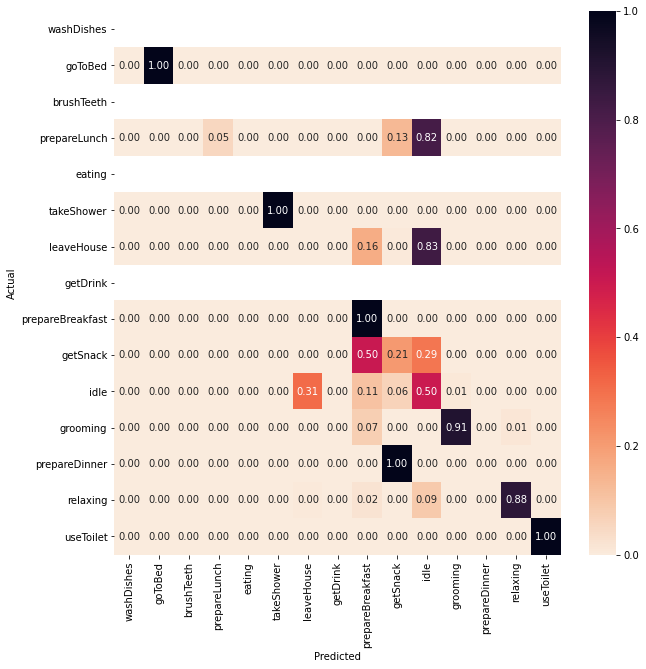

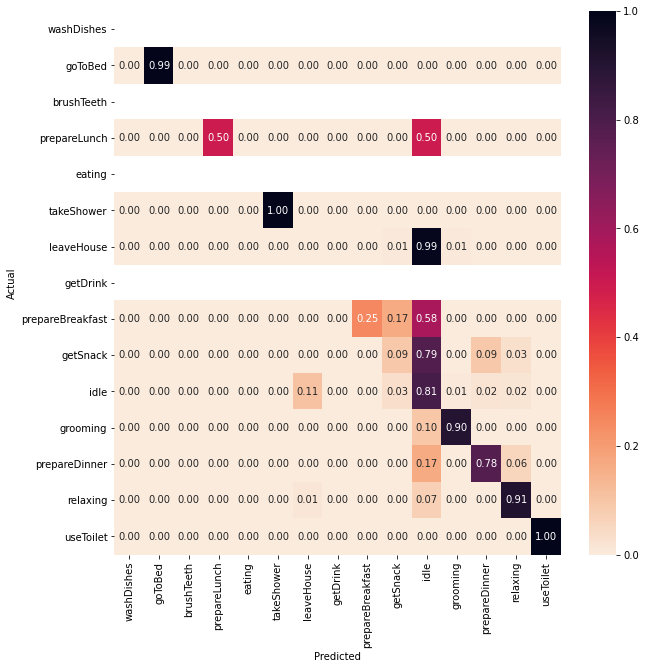

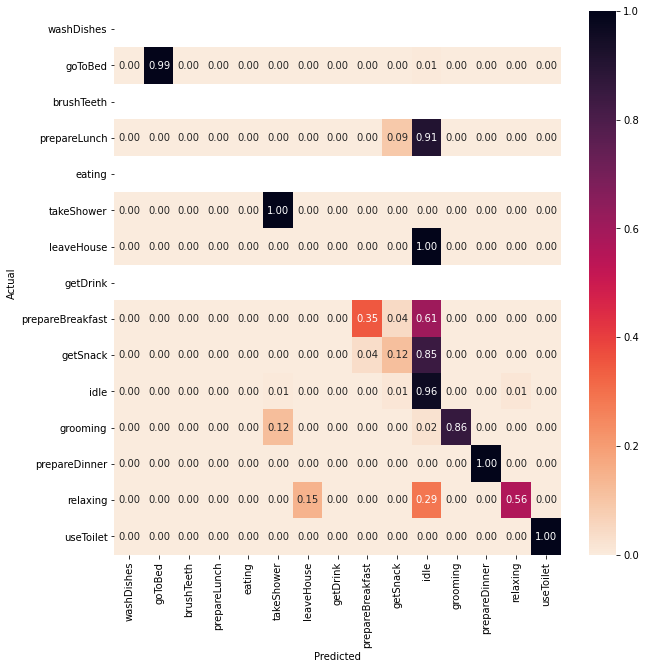

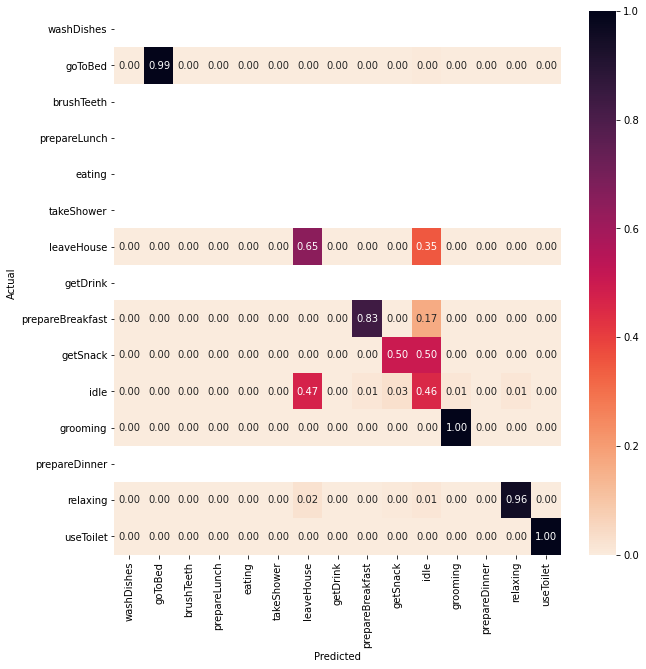

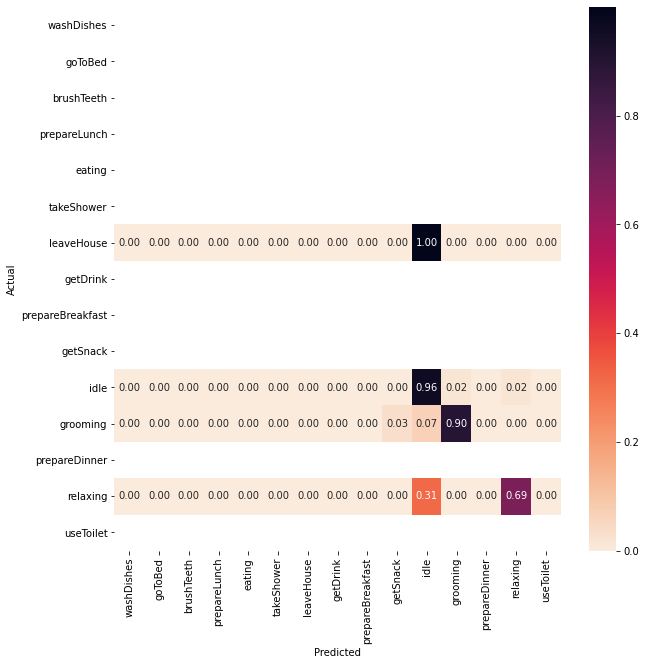

In [286]:
config = {
    "batch_size": 32,
    "ActivityIdList":
       [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

    "merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "Idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "Idle",
        "Respirate": "relaxing",
        "Work": "Idle",
        "Housekeeping": "Idle",
        "watchTV": "relaxing"
    }
}

houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']

i = 0
    
# path = os.path.join('../../../../Research/logs/graph_leave_one_out', 'graph_embedding_raw.npy')
path = os.path.join('../../../../Research/logs/master/master_raw_representation_all_house_dicts.npy')
result_dicts = np.load(path, allow_pickle=True)[()]
mat = 0
for i, result_dict in enumerate(result_dicts):
    mat  = result_dict['test_per_class_accuracy']    
    print('---------------------------------------------------------------------------------------------')
    print(houses[i])
    print('f1_score', result_dict['test_f1_score'])
    print('\n test_per_class_accuracy', result_dict['test_per_class_accuracy'])
    #     result_dict_list.append(result_dict[i]['test_per_class_accuracy'])
    print('\n accuracy', result_dict['test_acc'])    
    
    
    target_names = [getClassnameFromID(x) for x in np.arange(0, 15)]


    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Normalise
    cmn = np.array(mat).astype('float') /  mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='rocket_r')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
#     plt.show(block=False)    

  
    plt.savefig('./images/cf_matrices/master_leave_one_house_out/' + houses[i] + '_cf_matrix.png')

## Box plot for Leave one Day out and f1-score and accuracy for sum of CF matrix

In [25]:
from sklearn.metrics import f1_score
import os
import matplotlib.pyplot as plt
from pylab import *

config = {
    "batch_size": 32,
    "ActivityIdList":
       [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

    "merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "Idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "Idle",
        "Respirate": "relaxing",
        "Work": "Idle",
        "Housekeeping": "Idle",
        "watchTV": "relaxing"
    }
}

houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']



def comp_prec_recall(cfm):    
        lst_prec, lst_rec = [], []
        all_pred, all_gt = [], []
        for i, cn in enumerate(range(len(cfm))):
            tp = cfm[i, i]            
            pred = np.sum(cfm[:, i])
            all_pred.append(cfm[:, i])
            
            gt = np.sum(cfm[i, :])
            all_gt.append(cfm[i, :])
            
            fp = pred - tp
            fn = gt - tp

            prec = tp / (tp + fp)
            lst_prec.append(prec)
            
            rec = tp / (tp + fn)
            lst_rec.append(rec)
        print(f1_score(np.array(all_gt).ravel(), np.array(all_pred).ravel(), average='macro'))
        return lst_prec, lst_rec
    

def cal_f1_score(confusion_matrix):
#     print(np.array(cm).shape[0])
    num_classes = np.array(confusion_matrix).shape[0]
    total = np.sum(confusion_matrix)    
    TP = np.diag(confusion_matrix)    
    FP = confusion_matrix.sum(axis=0) - TP
    FN = confusion_matrix.sum(axis=1) - TP    
    TN = np.sum(confusion_matrix)- (FP + FN + TP)    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score =  2 * precision * recall / (precision + recall)
    f1_score = [0 if np.math.isnan(x) else x for x in f1_score]    
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    return f1_score, accuracy

for house in houses:
    i = 0
# For raw sensor data
#     path = os.path.join('../../../../Research/logs/' + house + '/raw_data_' + house + '_results_dict.npy')

# for graph embedding data 
    path = os.path.join('../../../../Research/logs/new_logs_graph_embedding/raw_graph_embedding_'
                        + house +  '_results_dict.npy')
  
    
    result_dicts = np.load(path, allow_pickle=True)[()]
    
    mat = 0
    house_f1_score = []

    # Calculate sum f1 score 
    all_cm = []
    for k in range(len(result_dicts['confusion_matrix'])):
        cm = np.array(result_dicts['confusion_matrix'][k])
        all_cm.append(cm)
    sum_cm =  np.sum(all_cm, axis =0)
    
    
    sum_f1_score, accuracy = cal_f1_score(sum_cm)
    
#     print(house)
#     print('sum of f1 score',np.mean(sum_f1_score))
#     print('sum of accuracy',np.mean(accuracy))    
    
    print(np.mean(sum_f1_score))
    
    # calculate individual f1_scores 
    for k in range(len(result_dicts['confusion_matrix'])):
        cm = np.array(result_dicts['confusion_matrix'][k])    
        f1_score, _ = cal_f1_score(cm)
        house_f1_score.append(np.mean(f1_score))      

#     print(house_f1_score)
#     print('\n\n')
  
    ## figure related code
#     fig = plt.figure()

#     ax = fig.add_subplot(111)
#     ax.boxplot(house_f1_score)

#     ax.set_title(house)
#     ax.set_ylabel('F1-Score')
#     plt.savefig('./images/box_plot/Embedding_leave_oneDay_out/' + house + '.png')


0.46302649676799773
0.1865568203230699
0.1568071639475723
0.23089835296074548
0.4230582475662231


/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide
/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


# Image box plot leave one day out

In [17]:
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from pylab import *

config = {
    "batch_size": 32,
    "ActivityIdList":
       [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

    "merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": " grooming",
        "shave": "grooming",
        "takeMedication": "Idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "Idle",
        "Respirate": "relaxing",
        "Work": "Idle",
        "Housekeeping": "Idle",
        "watchTV": "relaxing"
    }
}

houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']


def comp_prec_recall(cfm):    
        lst_prec, lst_rec = [], []
        all_pred, all_gt = [], []
        for i, cn in enumerate(range(len(cfm))):
            tp = cfm[i, i]            
            pred = np.sum(cfm[:, i])
            all_pred.append(cfm[:, i])
            
            gt = np.sum(cfm[i, :])
            all_gt.append(cfm[i, :])
            
            fp = pred - tp
            fn = gt - tp

            prec = tp / (tp + fp)
            lst_prec.append(prec)
            
            rec = tp / (tp + fn)
            lst_rec.append(rec)
        print(f1_score(np.array(all_gt).ravel(), np.array(all_pred).ravel(), average='macro'))
        return lst_prec, lst_rec
    

def cal_f1_score(confusion_matrix):
#     print(np.array(cm).shape[0])
    num_classes = np.array(confusion_matrix).shape[0]
    total = np.sum(confusion_matrix)    
    TP = np.diag(confusion_matrix)    
    FP = confusion_matrix.sum(axis=0) - TP
    FN = confusion_matrix.sum(axis=1) - TP    
    TN = np.sum(confusion_matrix)- (FP + FN + TP)    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score =  2 * precision * recall / (precision + recall)
    f1_score = [0 if np.math.isnan(x) else x for x in f1_score]    
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    return f1_score, accuracy



path = os.path.join('../../../../Research/logs/cnn_image_lstmraw_small_images_with_lstm.npy')


result_dicts = np.load(path, allow_pickle=True)[()]

mat = 0
house_f1_score = []

 # Calculate sum f1 score 
all_cm = []
for k in range(len(result_dicts['confusion_matrix'])):
    cm = np.array(result_dicts['confusion_matrix'][k])
    all_cm.append(cm)

sum_cm =  np.sum(all_cm, axis =0)


sum_f1_score, accuracy = cal_f1_score(sum_cm)

print(house)
print('sum of f1 score',np.mean(sum_f1_score))
print('sum of accuracy',np.mean(accuracy))       

# calculate individual f1_scores 
for k in range(len(result_dicts['confusion_matrix'])):
    cm = np.array(result_dicts['confusion_matrix'][k])    
    f1_score, _ = cal_f1_score(cm)
    house_f1_score.append(np.mean(f1_score))      

# print(house_f1_score)

# # figure related code
# fig = plt.figure()

# ax = fig.add_subplot(111)
# ax.boxplot(house_f1_score)

# ax.set_title('houseB')
# ax.set_ylabel('F1-Score')
# plt.savefig('./images/box_plot/images_leave_oneDay_out/' + 'houseB.png')


ordonezA
sum of f1 score 0.11308247447013856
sum of accuracy 0.9575647


/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/home/harsh/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


In [167]:
a = [[1,1,1], [2,2,2]]
b = [[1,1,1], [2,2,2]]
c= [a,b]
np.sum(c, axis = 0)

array([[3, 3, 3],
       [3, 3, 3]])

In [116]:
result_dicts['confusion_matrix']

[tensor([[  0.,   0.,   0.,   1.,   0.,   6.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0., 575.,   0.,  10.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0., 301.,   5.,  49.,   0.,   0.,   0.,   2.],
         [  0.,   0.,   0.,   0.,   0., 396.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   1.],
         [  0.,   0.,   0.,  42.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   3.,   0.,   2.,   0.,   0.,   0.,   1.]]),
 tensor([[  0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   0.,   0., 402.,   0., 206.,   0.,   0.,   0.,   1.],
    

## Master Results

In [7]:
path = os.path.join('../../../../Research/logs/master/', 'master_raw_representation_all_house_dicts.npy')

houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
# path = os.path.join('../../../dgl/logs/graph_classification/raw.npy')

test_matrix = 0
result_dict = np.load(path, allow_pickle=True)[()]
for i in range(len(result_dict)):    
    test_matrix =  result_dict[i]['test_per_class_accuracy']
    break
    print('---------------------------------------------------------------------------------------------')
    print(houses[i] + '\n')    
    print('f1_score', result_dict[i]['test_f1_score'])
#     print('\n test_per_class_accuracy', result_dict[i]['test_per_class_accuracy'])
    print('\n accuracy', result_dict[i]['test_acc'])

## Convert from dict to excel table

In [29]:
import pandas as pd

# Create a Pandas dataframe from some data.
df = pd.DataFrame(result_dict_list)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter("../../../dgl/pandas_table.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object. Turn off the default
# header and index and skip one row to allow us to insert a user defined
# header.
df.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False, index=False)

# Get the xlsxwriter workbook and worksheet objects.
workbook = writer.book
worksheet = writer.sheets['Sheet1']

# Get the dimensions of the dataframe.
(max_row, max_col) = df.shape

# Create a list of column headers, to use in add_table().
column_settings = []
for header in df.columns:
    column_settings.append({'header': header})

# Add the table.
worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings})

# Make the columns wider for clarity.
worksheet.set_column(0, max_col - 1, 12)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [7]:
import dgl
import numpy as np
import torch
import pandas as pd
import json
from torch.utils.data import DataLoader
import torch.nn as nn
import dgl.nn.pytorch as dglnn
import torch.nn.functional as F
import os
from sklearn.preprocessing import MinMaxScaler

# Breaking one big Graph embeddings of all house into different house, doing it for both OB and RAW

In [21]:
for run_config in ['ob']:
    config = {}
    if run_config is 'ob':
        config["house_start_end_dict"] = [{'ordonezB': (0, 2487)}, {'houseB': (2487, 4636)},
                                                      {'houseC': (4636, 6954)}, {'houseA': (6954, 7989)},
                                                      {'ordonezA': (7989, 8557)}]
    elif run_config is 'raw':
        config["house_start_end_dict"] = [{'ordonezB': (0, 30470)}, {'houseB': (30470, 51052)},
                                          {'houseC': (51052, 77539)}, {'houseA': (77539, 114626)},
                                          {'ordonezA': (114626, 134501)}]
    if run_config is 'ob':
        csvfile = open("../../../data/all_houses/ob_graph_embeddings.csv", 'r').readlines()
    elif run_config is 'raw':
        csvfile = open("../../../data/all_houses/raw_graph_embeddings.csv", 'r').readlines()

    for house_dict in config["house_start_end_dict"]:
        house_name, (start, end) = list(house_dict.items())[0]
        open(os.path.join('../../../data', house_name, run_config + '_' +  house_name + '_graph_Embeddings.csv'), 'w+').writelines(csvfile[start:end])
        open(os.path.join('../../../../Research/data', house_name, run_config + '_' +  house_name + '_graph_Embeddings.csv'), 'w+').writelines(csvfile[start:end])

In [22]:
os.chdir('/home/harsh/Downloads/Thesis/Graph/dgl/examples/pytorch/gin')

In [ ]:
'../../../data/'

# Adhoc

In [16]:
houseB = pd.read_csv('../../data/houseA/ob_houseA.csv')
np.unique(houseB['activity'])

array(['brushTeeth', 'getDrink', 'getSnack', 'goToBed', 'idle',
       'leaveHouse', 'prepareBreakfast', 'prepareDinner', 'takeShower',
       'useToilet'], dtype=object)

In [29]:
import pandas as pd
house = pd.read_csv('../../data/houseA/houseA.csv')

In [30]:
def obr(timesteps, X, y):

    all_data_pts = np.zeros((X.shape[0], timesteps, X.shape[1]), dtype = 'int64')
    data_pts = np.zeros((timesteps, X.shape[1]), dtype = 'int64')

    for index in range(X.shape[0]-1, -1, -1):
        
        current_idx = index
        delta_t = np.zeros(timesteps, dtype = 'int64')
        
        for timestep in range(timesteps-1, -1, -1):
            
            idx = current_idx
            for i in range(idx, 0, -1):
                if np.array_equal(X[i], X[i-1]):
                    delta_t[timestep] = delta_t[timestep] + 1
                    if i == 1:
                        data_pts[timestep] = X[idx]
                        current_idx = i-1
                else:
                    data_pts[timestep] = X[idx]
                    current_idx = i-1
                    break
                
        delta_t = delta_t + 1
        all_data_pts[index] = data_pts

    all_labels = y[(timesteps-1):y.shape[0]]
    for j in range(timesteps-1):
        all_data_pts = np.delete(all_data_pts, (j), axis = 0)

    return all_data_pts, all_labels

In [31]:
x = house.iloc[:, 3:].values
y =  house.iloc[:, 2].values

In [32]:
all_data_pts, all_labels = obr(1, x, y)

In [33]:
pd.('demo.csv',pd.DataFrame(all_data_pts))

AttributeError: module 'pandas' has no attribute 'to_csv'

In [28]:
print(list(all_data_pts[0][0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
houseA = pd.read_csv('../../data/houseA/houseA.csv')

In [2]:
import scipy.io
dataset = scipy.io.loadmat('/home/harsh/Downloads/Thesis/Datasets/kasterenDataset/kasterenDataset.mat')

In [3]:
dataset

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Jul 02 17:02:23 2008',
 '__version__': '1.0',
 '__globals__': [],
 'ss': MatlabObject([[(array([[7.33463014e+05, 7.33463016e+05, 2.40000000e+01, 1.00000000e+00],
        [7.33463398e+05, 7.33463398e+05, 2.40000000e+01, 1.00000000e+00],
        [7.33463398e+05, 7.33463723e+05, 2.40000000e+01, 1.00000000e+00],
        ...,
        [7.33488770e+05, 7.33488770e+05, 1.70000000e+01, 1.00000000e+00],
        [7.33488799e+05, 7.33488799e+05, 1.20000000e+01, 1.00000000e+00],
        [7.33490795e+05, 7.33490795e+05, 1.20000000e+01, 1.00000000e+00]]), array([[0]], dtype=uint8))]],
              dtype=[('d', 'O'), ('idishex', 'O')]),
 'as': MatlabObject([[(array([[7.33463016e+05, 7.33463399e+05, 1.00000000e+01],
        [7.33463401e+05, 7.33463401e+05, 4.00000000e+00],
        [7.33463409e+05, 7.33463412e+05, 1.30000000e+01],
        [7.33463418e+05, 7.33463425e+05, 5.00000000e+00],
        [7.33463430e+05, 7.33463705e+05, 1.00

# Merge all graph embeddings into one

In [27]:
import pandas as pd

In [28]:


config = {
"learning_rate" : 0.0001,
"num_epochs" : 10,
"decay" : 1e-5,
"hidden_dim" : 64,
"layer_dim" : 1,
"output_dim" : 15,
"seq_dim" : 2,
"batch_size" :32,
"split_ratio" : 0.2,
"num_workers":4,
"accumulation_steps": 1,
"no_of_subset":30 ,
"subset_overlap_length": 2 ,
"resize_width": 120,
"resize_height": 97,
"image_width": 663,
"image_height": 446,
"ActivityIdList":
         [{'name': 'washDishes', 'id': 0},
         {'name': 'goToBed', 'id': 1},
         {'name': 'brushTeeth', 'id': 2},
         {'name': 'prepareLunch', 'id': 3},
         {'name': 'eating', 'id': 4},
         {'name': 'takeShower', 'id': 5},
         {'name': 'leaveHouse', 'id': 6},
         {'name': 'getDrink', 'id': 7},
         {'name': 'prepareBreakfast', 'id': 8},
         {'name': 'getSnack', 'id': 9},
         {'name': 'idle', 'id': 10},
         {'name': 'grooming', 'id': 11},
         {'name': 'prepareDinner', 'id': 12},
         {'name': 'relaxing', 'id': 13},
         {'name': 'useToilet', 'id': 14}],

"merging_activties" : {
        "loadDishwasher": "washDishes",
        "unloadDishwasher": "washDishes",
        "loadWashingmachine": "washClothes",
        "unloadWashingmachine": "washClothes",
        "receiveGuest": "relaxing",
        "eatDinner": "eating",
        "eatBreakfast": "eating",
        "getDressed": "grooming",
        "shave": "grooming",
        "takeMedication": "idle",
        "leave_Home": "leaveHouse",
        "Sleeping": "goToBed",
        "Bed_to_Toilet": "useToilet",
        "Enter_Home": "idle",
        "Respirate": "relaxing",
        "Work": "idle",
        "Housekeeping": "idle",
        "Idle": "idle",
        "watchTV": "relaxing"
    }
}

def getClassnameFromID(train_label):
    ActivityIdList = config['ActivityIdList']
    train_label = [x for x in ActivityIdList if x["id"] == int(train_label)]
    return train_label[0]['name']

In [34]:
houses = ['ordonezB', 'houseB', 'houseC', 'houseA', 'ordonezA']
for run_config in ['raw']:
    li = []
    for house_name in houses:
#         path = "/data/" + house_name + "/" +  run_config + "_graph_embeddings.csv"        
        path = "../../../dgl/data/" + house_name + "/" +  run_config + "_graph_embeddings.csv"        
        
        df = pd.read_csv(path, index_col=None, header=0)
        df['activity'] = df['activity'].apply(lambda x: getClassnameFromID(x))
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
#     frame.to_csv('../../../dgl/data/all_houses/all_house_' + run_config + '_graph_embedding.csv', index=False)
#     frame.to_csv('../../../../Research/data/all_houses/all_house_' + run_config + '_graph_embedding.csv', index=False)
    frame.to_csv('../../../dgl/data/all_houses/all_house_' + run_config + '_graph_embeddings.csv', index=False)
    frame.to_csv('../../../../Research/data/all_houses/all_house_' + run_config + '_graph_embeddings.csv', index=False)
    

### Last fired sensor

In [35]:
import pandas as pd
import numpy as np
# Concatenate house csv with sensor change values
house_name = 'houseB'
house = pd.read_csv("../../../../Research/data/" + house_name + "/" + house_name + ".csv")
sensor_change = pd.read_csv("../../../../Research/data/" + house_name + "/house-sensorChangeTime.csv")
appending_dataframe_length  = len(sensor_change.iloc[0,3:-33])


sensor_change_cut_frame = pd.DataFrame(sensor_change.iloc[:, 3:-33].values, columns=np.arange(appending_dataframe_length))
house = house.join(sensor_change_cut_frame)
house.to_csv('../../../../Research/data/' + house_name + '/' + house_name + '_extended.csv', index=False)
print(len(house))
# house.iloc[0]

20582


In [84]:
demo = pd.DataFrame()
house_name = 'houseA'
house = pd.read_csv("../../../../Research/data/" + house_name + "/" + house_name + ".csv")


demo = demo.append(house[:4])